In [398]:
import pandas
import os
import matplotlib_venn_wordcloud
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from glob import glob
from scipy import stats
from scipy.io import savemat, loadmat
from nilearn import datasets, image, plotting, input_data
from sklearn import linear_model
from sklearn.cross_decomposition import PLSRegression, CCA, PLSCanonical
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
from statsmodels.sandbox.stats.multicomp import multipletests

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/wordcloud/wordcloud.py:31: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))


In [2]:
git_dir = '/home/users/jvogel/git/Hippocampus_AP_Axis/'

import sys
sys.path.insert(0,git_dir)
import HAP_Utils as hap

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


# Get hippocampus samples

In [3]:
wdir = os.path.join(git_dir, 'Data')
aba_dir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'

df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'))
xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)
gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'))
probes = pandas.read_csv(os.path.join(aba_dir,'normalized_microarray_donor9861/Probes.csv'))

In [321]:
# If you intende to save figures to disk, you will need to uncomment and change this

#fig_dir = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/'

In [312]:
# # PERSONAL COMPUTER
# wdir = '/Users/jakevogel/Science/AHBA/'
# df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'))
# xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)
# gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'))
# probes = pandas.read_csv('/Users/jakevogel/Downloads/normalized_microarray_donor9861/Probes.csv')

# Run main analysis pipeline to get variables

In [4]:
pcalr_out_NEW = hap.PCA_LR_pipeline(xp.values.T, 
                            (df.position_along_hipp_AP_axis), 
                            cv_strategy='score', illustrative=False,
                           test_gene_num = [100],
                               sanity_check_style = 'separate')

running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.675885977482217
running final model
final model fit r2 =  0.8768105093258057
running sanity_check


# HAGS Index across the brain
* Note: This next section requires you to run the code in NB1

In [10]:
# GET GENE EXPRESSION FOR HIPPOCAMPAL SAMPLES 
# loading this df takes awhile and may not work on computers without lots of memory 
# its about 60k x 4k
shtz = sorted(glob(os.path.join(aba_dir,'normalized_microarray_donor*/MExp_all_genes_ctr_for_donor')))
holder = []
for sht in shtz:
    holder.append(pandas.read_csv(sht,index_col=0))
bigdf = pandas.concat(holder,axis=1)
del(holder)
ncols = ['%s_%s'%(gdf.loc[x,'donor'],bigdf.columns[x]) for x in range(gdf.shape[0])]
bigdf.columns = ncols

#### Get HAGS index for all tissue sample across the brain

In [11]:
gcx_SPCR = hap.get_gene_vector(bigdf, gene_vec=pcalr_out_NEW['betas'])

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


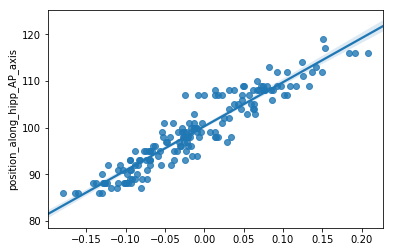

(0.9424780132848128, 7.277902789018465e-82)


In [46]:
# Sanity check
rs = []
for i,samp in enumerate(xp.columns):
    svec = xp[samp]
    refvec = pcalr_out_NEW['betas']
    r,p = stats.pearsonr(svec,refvec)
    rs.append(r)
plt.close()
sns.regplot(np.array(rs),df.position_along_hipp_AP_axis)
plt.show()
print(stats.pearsonr(np.array(rs),df.position_along_hipp_AP_axis))

## Associations between HAGS Index and sample X, Y and Z coordinate

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


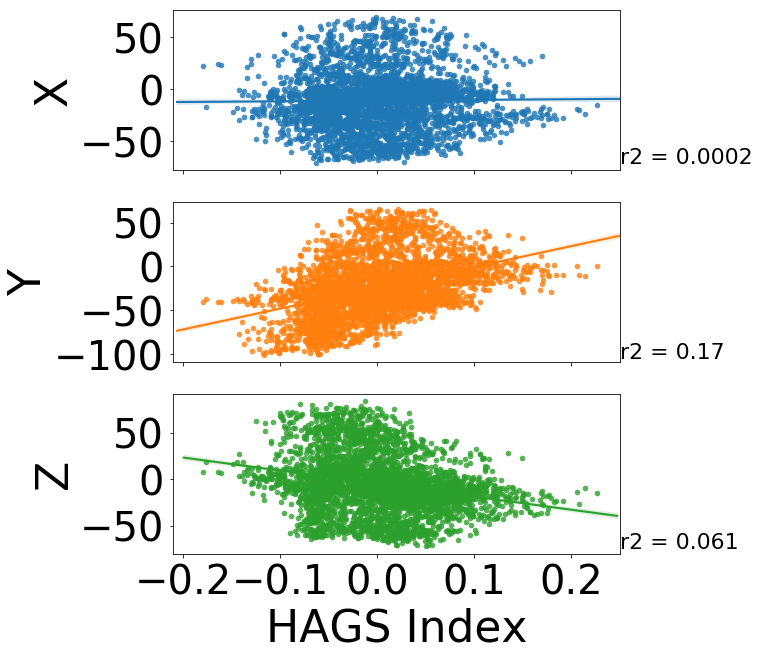

In [20]:
sns.set_context('paper',font_scale=5)
gcx_SPCR = gdf.AP_axis_gxp_signature_similarity_SPCR.values
plt.close()
fig,(ax1, ax2, ax3) = plt.subplots(3, figsize=(8,10))
sns.regplot(np.array(gcx_SPCR), gdf.mni_nlin_x, ax=ax1)
sns.regplot(np.array(gcx_SPCR), gdf.mni_nlin_y, ax=ax2)
sns.regplot(np.array(gcx_SPCR), gdf.mni_nlin_z, ax=ax3)
plt.xlabel('HAGS Index')
#ax1.set(ylabel='MNI X\nCoordinate')
ax1.set(ylabel='X')
ax1.set(xticks=[-0.2,-0.1,0,0.1,0.2])
ax1.set(xlim=(-0.21, 0.25))
ax1.set(xticklabels=['','','','',''])
#ax2.set(ylabel='MNI Y\nCoordinate')
ax2.set(ylabel='Y')
ax2.set(xticks=[-0.2,-0.1,0,0.1,0.2])
ax2.set(xlim=(-0.21, 0.25))
ax2.set(yticks=[-100,-50,0,50])
ax2.set(xticklabels=['','','','',''])
#ax3.set(ylabel='MNI Z\nCoordinate')
ax3.set(ylabel='Z')
ax3.set(xticks=[-0.2,-0.1,0,0.1,0.2])
ax3.set(xlim=(-0.21, 0.25))

xr = stats.pearsonr(np.array(gcx_SPCR), gdf.mni_nlin_x)[0]**2
yr = stats.pearsonr(np.array(gcx_SPCR), gdf.mni_nlin_y)[0]**2
zr = stats.pearsonr(np.array(gcx_SPCR), gdf.mni_nlin_z)[0]**2
#plt.text(0.11, 340,'r2 = %s'%float('%.2g'%xr), fontsize=22)
plt.text(0.25, 340,'r2 = %s'%float('%.2g'%xr), fontsize=22)
plt.text(0.25, 130,'r2 = %s'%float('%.2g'%yr), fontsize=22)
plt.text(0.25, -75,'r2 = %s'%float('%.2g'%zr), fontsize=22)
#plt.savefig(os.path.join(fig_dir,'XYZ_plots_revised.pdf',
#           bbox_inches='tight')
plt.show()


In [47]:
gdf.loc[:,'AP_axis_gxp_signature_similarity_SPCR'] = gcx_SPCR

In [50]:
gdf.to_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'),index=False)

## Plot the HAGS index across the whole brain

In [12]:
mni = os.path.join(wdir,'MNI152_T1_1mm_brain.nii.gz')
vec = gdf.AP_axis_gxp_signature_similarity_SPCR.values
input_coords = []
for i,row in gdf.iterrows():
    input_coords.append(hap.convert_coords([round(int(row['mni_nlin_x'])), 
                                        round(int(row['mni_nlin_y'])), 
                                        round(int(row['mni_nlin_z']))], 'xyz'))
nm = 'test'
gcx_img = hap.make_expression_image(vec, input_coords, mni, wdir, nm, 3, return_img=True)

In [53]:
from nilearn import plotting
plotting.view_img(gcx_img)

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


# Resting-state analysis

Here, we try to figure out the best Y-coordinate to split the hippocampus into anterior and posterior divisions. We do this by splitting the hippocampus along its axis, and then trying to "predict" if a sample is posterior or anterior based on gene expression information. The locations with the best prediction might make for a sensible split.

* To save you some time, I have stored the relevant neurosynth maps on open neuro for a swift one-click download. You will need to download this data to complete the following section. Find the data here: https://neurovault.org/collections/4964/. Just to be clear, these maps were all downloaded from Neurosynth, just saving some time.

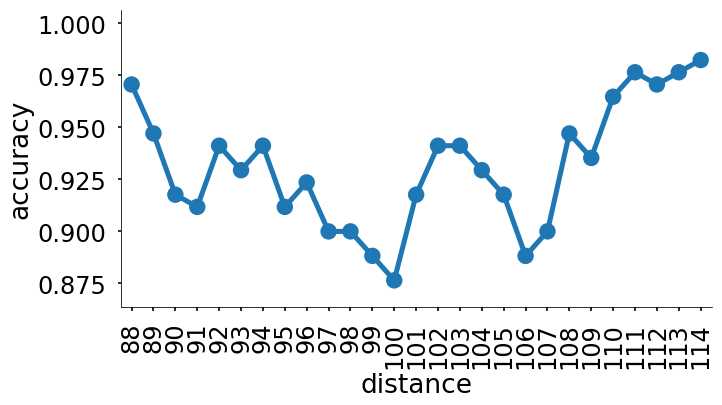

In [232]:
# Results spreadsheet
d_classifiers = pandas.DataFrame(index = range(88,115), columns = ['accuracy'])

# For y-coordinate between 88 and 115...
for i in range(88,115):
    # separate hippocampal tissue samples into "anterior" and "posterior"
    # based on orientation to i
    classes = [0 if x < i else 1 for x in df.position_along_hipp_AP_axis]
    # Run a logistic regression to try to predict split
    tmod = linear_model.LogisticRegressionCV().fit(np.array(rs).reshape(-1,1),classes)
    scr = tmod.score(np.array(rs).reshape(-1,1),classes)
    d_classifiers.loc[i,'accuracy'] = scr
d_classifiers.loc[:,'distance'] = d_classifiers.index

# PLOT
plt.close()
sns.set_context('poster', font_scale=1.5)
g = sns.factorplot(x='distance', y='accuracy', data=d_classifiers, size=6, aspect=1.8)
g.set_xticklabels(rotation=90)
plt.plot([94, 94], [0.87, 1], 'r--', linewidth=2)
#plt.savefig(os.path.join(fig_dir,'fmri_cutpoints.pdf'),
#           bbox_inches='tight')
plt.show()

In [5]:
# Get all the connectivity maps from each hippocampal coordinate

## CHANGE THIS TO THE DIRECTORY YOU STORED YOUR DATA IN 
NS_dir = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/rsfmri_neurosynth/'

cx_scans = sorted(glob(os.path.join(NS_dir,'*.nii.gz')))

# Get the coordinates of each
scoords = [[int(x[-3]),int(x[-2]),int(x[-1].split('.')[0])
           ] for x in [y.split('_') for y in cx_scans]]

# Find the tissue sample that is closest to the coordinate
for i,row in df.iterrows():
    c = [row['mni_nlin_x'],row['mni_nlin_y'],row['mni_nlin_z']]
    dists = [(abs(c[0] - sc[0]) + abs(c[1] - sc[1]) + abs(c[2] - sc[2])) for sc in scoords]
    gcx = np.argmin(dists)
    df.loc[i,'closest_cx_map'] = cx_scans[gcx]


#### Make some brain masks using the DKT and Harvard-Oxford atlases

In [53]:
#Load the atlases

dkt = ni.load(os.path.join(wdir,'dkt_atlas_1mm.nii.gz')).get_data()
HO = ni.load(os.path.join(wdir,'HarvardOxford-sub-maxprob-thr25-1mm.nii.gz')
            ).get_data()

#whole brain
msk1 = np.array(HO,copy=True)
msk1[HO<1] = 0

#no cereb or brainstem
msk2 = np.array(dkt, copy=True)
msk2[msk2>78] = 0
msk2 = np.array(dkt, copy=True)
msk2[msk2>78] = 0

# no cereb, brainstem or hippocampus
msk3 = np.array(msk2, copy=True)
msk3[dkt==36] = 0
msk3[dkt==75] = 0

# cortex only (no subcortex)
msk4 = np.array(msk3, copy=True)
msk4[dkt>31] = 0
msk4[dkt>41] = dkt[dkt>41]
msk4[dkt>70] = 0

#### Relationship between hippocampus connectivity and HAGS index

The following pipeline will:
* Create and average anterior and posterior hippocampus connectivity map, respectively, using input cut points, connectivity maps and coordinates.
* Use these to make a subtraction map representing relative anterior > posterior hippocampus connectivity to the rest of the brain
* Plot the relationship between a sample's HAGS index and its relative connectivity to the anterior vs. posterior hippocampus 

In [61]:
from importlib import reload
reload(hap)

<module 'HAP_Utils' from '/home/users/jvogel/git/Hippocampus_AP_Axis/HAP_Utils.py'>

24 maps used for posterior, 50 used for anterior


processing anterior image
making mean image
resampling
processing posterior image
making mean image
resampling
running analysis


/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


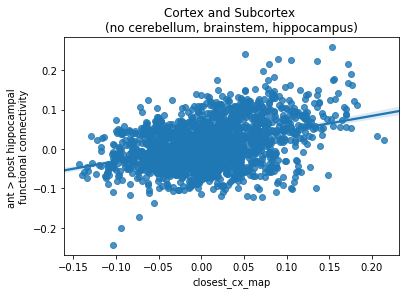

standard statistics: r2 = 0.147430123973424, p = 7.759116953668909e-70
saving images


r2            p
3  0.14743  7.75912e-70

In [62]:
ant_cut = 94
post_cut = 108
ycol = 'position_along_hipp_AP_axis'
ccol = 'closest_cx_map'
msk = msk3
gcx_col = 'AP_axis_gxp_signature_similarity_SPCR'
plabs = ['Cortex and Subcortex \n(no cerebellum, brainstem, hippocampus)',
         ccol,'ant > post hippocampal \nfunctional connectivity']
#in_imgs = ['/Users/jakevogel/Science/AHBA/ant_img.nii.gz',
#          '/Users/jakevogel/Science/AHBA/post_img.nii.gz']
in_imgs = []
hap.run_hipp_connectivity_analysis(ant_cut, post_cut, df, ycol,
                                   ccol, wdir, gdf, msk, gcx_col, plabs,
                                   del_img = True, diff_img = True,  vrad = 3,
                                  in_imgs = in_imgs, bootstrap = False, hue_vals=[],
                                  return_results=True, tspace=mni, save_dir=wdir)

#### Repeat across different anterior/posterior cut coordinates, brainmasks, and extraction window sizes

In [37]:
## THIS WILL TAKE A LONG TIME TO RUN

# Initialize some stuff

dmin = min(df.position_along_hipp_AP_axis)+1
dmax = max(df.position_along_hipp_AP_axis)-4
drange = int((dmax-dmin)/2)
vrad = [1,2,3,4,5,6]
msks = [msk1,msk2,msk3,msk4]
resdf = pandas.DataFrame(index=range(drange*len(msks)*len(vrad)),
                                      columns = ['ant_cut','post_cut','n_ant','n_post',
                                                 'mask','vs','r2','p', 'manual_FDR',
                                                 'chance_r2', 'ci_l', 'ci_u'])
cnt = 0
# For each set of cut points
for i in range(drange+1):
    # ID cut points
    ant_cut = dmin+i
    post_cut = dmax-i
    n_ant = len(df[df.position_along_hipp_AP_axis<dmin+i])
    n_post = len(df[df.position_along_hipp_AP_axis>dmax-i])
    # Store cut point and number of anterior and posterior samples
    resdf.loc[resdf.index[cnt:cnt+(len(msks)*len(vrad))],'ant_cut'] = [ant_cut] * len(msks)*len(vrad)
    resdf.loc[resdf.index[cnt:cnt+(len(msks)*len(vrad))],'post_cut'] = [post_cut] * len(msks)*len(vrad)
    resdf.loc[resdf.index[cnt:cnt+(len(msks)*len(vrad))],'n_ant'] = [n_ant] * len(msks)*len(vrad)
    resdf.loc[resdf.index[cnt:cnt+(len(msks)*len(vrad))],'n_post'] = [n_post] * len(msks)*len(vrad)
    # Initialize some variables relating to the rsfmri pipeline
    ycol = 'position_along_hipp_AP_axis'
    ccol = 'closest_cx_map'
    gcx_col = 'AP_axis_gxp_signature_similarity_SPCR'
    plabs = ['Cortex and Subcortex \n(no cerebellum, brainstem, hippocampus)',
             ccol,'ant > post hippocampal \nfunctional connectivity']
    # For each brainmask
    for m,msk in enumerate(msks):
        # Store mask
        lab = 'msk%s'%(m+1)
        resdf.loc[resdf.index[cnt:(cnt+len(vrad))],'mask'] = [lab]*len(vrad)
        # Run rsfmri analysis, including permutation tests
        res = hap.run_hipp_connectivity_analysis(ant_cut, post_cut, df, ycol, 
                                       ccol, wdir, gdf, msk, gcx_col, plabs,
                                       del_img = True, diff_img = True,  vrad = vrad,
                                      in_imgs = [], bootstrap = 'bootstrap', hue_vals=[],
                                      return_results=True, illustrative=False, n_iter = 100)
        # Store results
        resdf.loc[resdf.index[cnt:(cnt+len(vrad))],'vs'] = res.index
        resdf.loc[resdf.index[cnt:(cnt+len(vrad))],
                  ['r2','p','manual_FDR','chance_r2', 'ci_l', 'ci_u']] = res.values
        cnt+=len(vrad)
        # Save results after each iteration
        #resdf.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/hipp_cx_analysis_bootstrap.csv')

In [261]:
#resdf = pandas.read_csv('/Users/jakevogel/Science/AHBA/hipp_cx_analysis_permute.csv',
#                       index_col=0)

In [274]:
resdf.head()

ant_cut  post_cut  n_ant  n_post         mask  Voxel Radius        r2  \
0       87       115      5       5  Whole Brain             1  0.186267   
1       87       115      5       5  Whole Brain             2  0.189239   
2       87       115      5       5  Whole Brain             3  0.193634   
3       87       115      5       5  Whole Brain             4  0.199146   
4       87       115      5       5  Whole Brain             5  0.205578   

               p  manual_FDR  chance_r2          ci_l      ci_u    Split  \
0  3.153058e-154         0.0   0.000283  1.014456e-06  0.001045  87\n115   
1  6.267558e-157         0.0   0.000290  1.489335e-06  0.001190  87\n115   
2  6.088995e-161         0.0   0.000302  1.191315e-06  0.001166  87\n115   
3  5.244619e-166         0.0   0.000286  1.435880e-06  0.001059  87\n115   
4  5.838083e-172         0.0   0.000311  8.281229e-07  0.001221  87\n115   

   Split ID  
0         0  
1         0  
2         0  
3         0  
4         0

A few steps to prepare plot...

In [264]:
msk_dict = {'msk1': 'Whole Brain', 'msk2': 'No Cerebellum\nor Brainstem',
           'msk3': 'No Cerebellum\nBrainstem or\nHippocampus','msk4': 'Cortex Only'}
resdf['mask'] = [msk_dict[x] for x in resdf['mask']]
resdf.loc[:,'Split'] = [
        '%s\n%s'%(resdf.loc[x,'ant_cut'],resdf.loc[x,'post_cut']) for x in range(len(resdf))]
resdf.columns = resdf.columns[:5].tolist() + ['Voxel Radius'] + resdf.columns[6:].tolist()


In [266]:
split_tix = [resdf.Split.unique()[x] for x in range(0,len(resdf.Split.unique()),3)]
split_dict = dict(zip(resdf.Split.unique(),range(len(resdf.Split.unique()))))
resdf.loc[:,'Split ID'] = [split_dict[x] for x in resdf.Split]

Aaaaaand plot it

//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


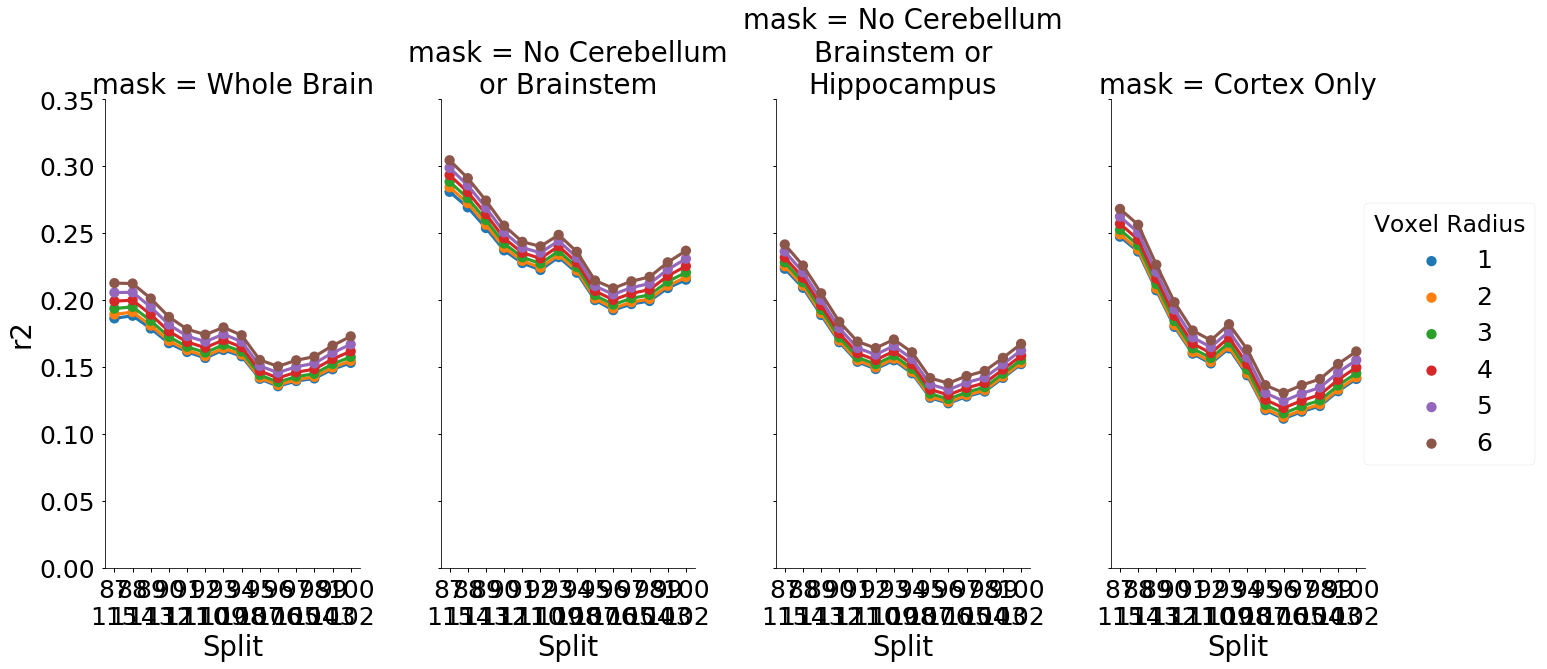

In [284]:
sns.set_context('notebook',font_scale=2.5)
plt.close()
sns.factorplot(x='Split', y='r2', hue='Voxel Radius', col='mask', 
               data=resdf, size=10, aspect=.5)
#plt.xticks(split_tix)
#plt.yticks([0.1, 0.15, 0.2, 0.25, 0.3])
#plt.savefig(os.path.join(fig_df,'Hipp_Control_analysis.pdf'),
#           bbox_inches = 'tight')
plt.ylim(0,0.35)
plt.show()

//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


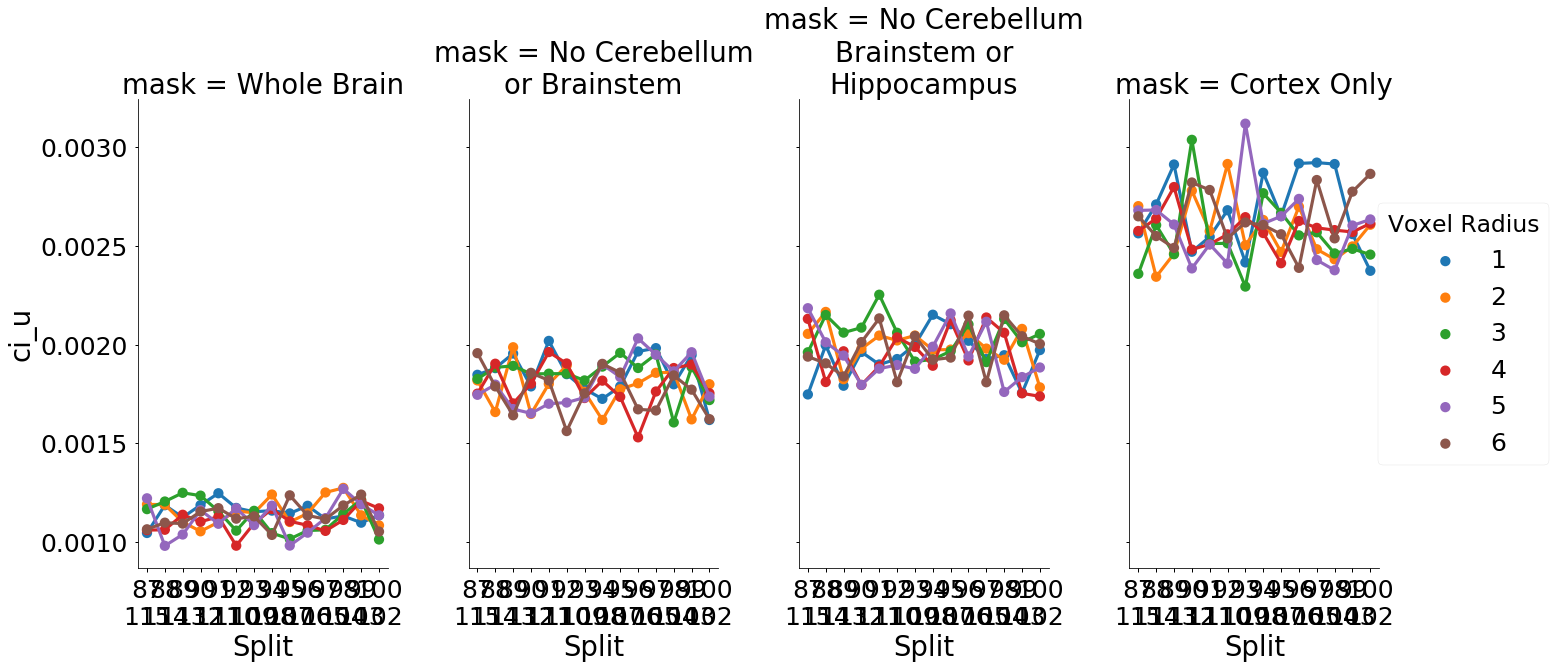

In [288]:
# COMPARED TO THE RANDOM PERMUTATIONS... (plotting the upper 95% confidence interval of the r2 here...)

sns.set_context('notebook',font_scale=2.5)
plt.close()
sns.factorplot(x='Split', y='ci_u', hue='Voxel Radius', col='mask', data=resdf, size=10, aspect=.5)
#plt.fill(resdf.ci_l, resdf.ci_u)
#plt.ylim(0,0.3)
#plt.xticks(split_tix)
#plt.yticks([0.1, 0.15, 0.2, 0.25, 0.3])
#plt.savefig(os.path.join(fig_dir,'Hipp_Control_analysis.pdf'),
#           bbox_inches = 'tight')
plt.show()

#### Number of samples across splits

In [196]:
jnk = pandas.concat([resdf[['Split','n_ant']],
                    resdf[['Split','n_post']]])
jnk.index = range(len(jnk.index))
jnk.columns = ['Split', 'n', 'Structure']
jnk.loc[jnk.index[len(resdf):],'n'] = resdf.n_post.values
jnk.loc[:,'Structure'] = (['Posterior'] * len(resdf)) + (['Anterior'] * len(resdf)) 

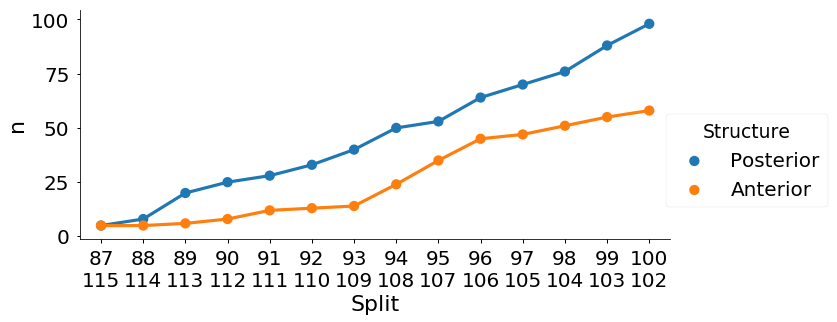

In [203]:
sns.set_context('notebook',font_scale=2)
plt.close()
sns.factorplot(x='Split', y='n', hue= 'Structure', data=jnk, size=5, aspect=2)
#plt.savefig(os.path.join(fig_dir,'Hipp_Control_n.pdf'),
#           bbox_inches = 'tight')
plt.show()

# FDG Analysis
You will need to download the image, found at: https://neurovault.org/collections/4756/

Initially, running the analysis in native (1.5 mm) space

In [17]:
# Load HAGS map and FTD > AD tmap
fdg_dir = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/AD-FTD FDG Difference Map/'
gcx = gcx_img
tmap_GN = ni.load(os.path.join(fdg_dir,'AD-FTD_globalnorm2.nii.gz')).get_data()

Load some masks in 1.5mm space

In [43]:
dkt = image.resample_to_img(os.path.join(wdir,'dkt_atlas_1mm.nii.gz'),
                            os.path.join(fdg_dir,'AD-FTD_globalnorm2.nii.gz'),
                            interpolation='nearest').get_data()
HO = image.resample_to_img(os.path.join(wdir,'HarvardOxford-sub-maxprob-thr25-1mm.nii.gz'),
                        os.path.join(fdg_dir,'AD-FTD_globalnorm2.nii.gz'),
                        interpolation='nearest').get_data()

#whole brain
msk1 = np.array(HO,copy=True)
msk1[HO<1] = 0

#no cereb or brainstem
msk2 = np.array(dkt, copy=True)
msk2[msk2>78] = 0
msk2 = np.array(dkt, copy=True)
msk2[msk2>78] = 0

# no cereb, brainstem or hippocampus
msk3 = np.array(msk2, copy=True)
msk3[dkt==36] = 0
msk3[dkt==75] = 0

# cortex only (no subcortex)
msk4 = np.array(msk3, copy=True)
msk4[dkt>31] = 0
msk4[dkt>41] = dkt[dkt>41]
msk4[dkt>70] = 0

Here, we are plotting the relationship between a sample's HAGS index and its relative vulnerability to FTD over AD, using 4 different brain masks

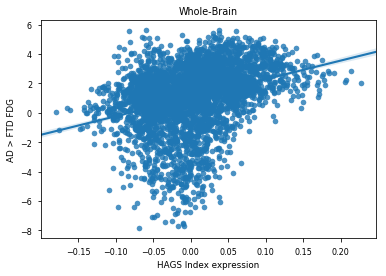

standard statistics: r2 = 0.103019698847, p = 3.48910427809e-89


KeyboardInterrupt: 

In [305]:
msks = [msk1,msk2,msk3,msk4,dkt]
sns.set_context('paper')

img = tmap_GN
vrad=3
vdim = 1.5
gcx_col='AP_axis_gxp_signature_similarity_SPCR'
bootstrap = False
plabs = ['Whole-Brain',
         'HAGS Index expression','AD > FTD FDG']
for mask in msks:
    msk = np.array(mask,copy=True) 
    msk[img==0] = 0
    hap.run_gvfcx_analysis(img, gdf, msk, vrad, vdim, gcx_col, plabs, 
                           bootstrap, n_iter=10, hue_vals=[], illustrative=True)

And here, we repeat the analysis, vary the size of the extraction window, and store the results

In [36]:
vrad = [1,2,3,4,5,6]
msks = [msk1,msk2,msk3,msk4]
resdf = pandas.DataFrame(index=range(len(msks)*len(vrad)),
                                      columns = ['mask','vs','r2','p'])
cnt = 0
ycol = 'position_along_hipp_AP_axis'
ccol = 'closest_cx_map'
gcx_col = 'AP_axis_gxp_signature_similarity_SPCR'
plabs = ['Cortex and Subcortex \n(no cerebellum, brainstem, hippocampus)',
         ccol,'ant > post hippocampal \nfunctional connectivity']
for m,mask in enumerate(msks):
    msk = np.array(mask,copy=True) 
    msk[img==0] = 0
    lab = 'msk%s'%(m+1)
    resdf.loc[resdf.index[cnt:(cnt+len(vrad))],'mask'] = [lab]*len(vrad)
    res = hap.run_gvfcx_analysis(img, gdf, msk, vrad, vdim, gcx_col, plabs, 
                               bootstrap=False, n_iter=10, hue_vals=[], illustrative=False)
    resdf.loc[resdf.index[cnt:(cnt+len(vrad))],'vs'] = res.index
    resdf.loc[resdf.index[cnt:(cnt+len(vrad))],['r2','p',]] = res.values
    cnt+=len(vrad)
    resdf.to_csv('/Users/jakevogel/Science/AHBA/AD_FTD_HAGS_analysis')

standard statistics: r2 = 0.0953458118362, p = 2.40805102453e-82
standard statistics: r2 = 0.0987310577193, p = 2.35366292708e-85
standard statistics: r2 = 0.103019698847, p = 3.48910427809e-89
standard statistics: r2 = 0.107440966081, p = 3.77132286294e-93
standard statistics: r2 = 0.111510464226, p = 8.10583202345e-97
standard statistics: r2 = 0.115522956538, p = 1.88934368964e-100
standard statistics: r2 = 0.107289522824, p = 7.60550124135e-55
standard statistics: r2 = 0.110074531871, p = 2.63578543817e-56
standard statistics: r2 = 0.114258310502, p = 1.65567337855e-58
standard statistics: r2 = 0.119180530404, p = 4.12528786146e-61
standard statistics: r2 = 0.124208161569, p = 8.74066636048e-64
standard statistics: r2 = 0.129603678308, p = 1.13577976502e-66
standard statistics: r2 = 0.107114960594, p = 6.53415997944e-50
standard statistics: r2 = 0.11002259916, p = 2.68962016552e-51
standard statistics: r2 = 0.114553175964, p = 1.82869567753e-53
standard statistics: r2 = 0.1200387753

And then plot it

In [38]:
msk_dict = {'msk1': 'Whole Brain', 'msk2': 'No Cerebellum\nor Brainstem',
           'msk3': 'No Cerebellum\nBrainstem or\nHippocampus','msk4': 'Cortex Only'}
resdf['mask'] = [msk_dict[x] for x in resdf['mask']]
resdf.columns = ['Mask','Voxel Radius'] + resdf.columns[2:].tolist()

//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


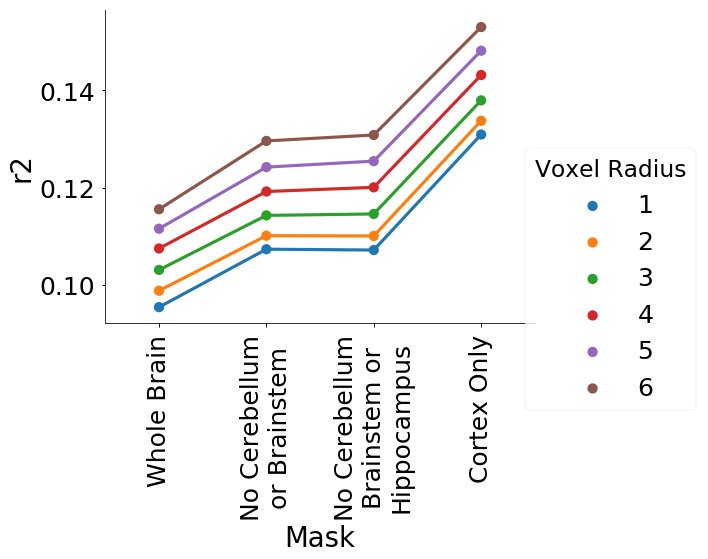

In [51]:
sns.set_context('notebook',font_scale=2.5)
plt.close()
f = sns.factorplot(x='Mask', y='r2', hue='Voxel Radius', data=resdf, size=7, aspect=1.2)
f.set_xticklabels(rotation=90)
#plt.xticks(split_tix)
#plt.yticks([0.1, 0.15, 0.2, 0.25, 0.3])
plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/AD_FTD_control_analysis.pdf',
           bbox_inches = 'tight')
plt.show()

# Structural covariance

Get OASIS VBM data...

In [103]:
from nilearn import datasets, image, plotting, input_data

In [104]:
data = datasets.fetch_oasis_vbm()

/home/users/jvogel/.local/lib/python3.6/site-packages/numpy/lib/npyio.py:2278: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [105]:
data.keys()

dict_keys(['gray_matter_maps', 'white_matter_maps', 'ext_vars', 'data_usage_agreement', 'description'])

In [106]:
demos = pandas.DataFrame(data.ext_vars)
demos.head()

id    mf  hand  age  educ  ses  mmse  cdr  etiv   nwbv  \
0  b'OAS1_0001_MR1'  b'F'  b'R'   74     2    3    29  0.0  1344  0.743   
1  b'OAS1_0002_MR1'  b'F'  b'R'   55     4    1    29  0.0  1147  0.810   
2  b'OAS1_0003_MR1'  b'F'  b'R'   73     4    3    27  0.5  1454  0.708   
3  b'OAS1_0004_MR1'  b'M'  b'R'   28    -1   -1    -1  NaN  1588  0.803   
4  b'OAS1_0005_MR1'  b'M'  b'R'   18    -1   -1    -1  NaN  1737  0.848   

     asf   delay  
0  1.306  b'N/A'  
1  1.531  b'N/A'  
2  1.207  b'N/A'  
3  1.105  b'N/A'  
4  1.010  b'N/A'

In [107]:
# Identify how many individuals who are young healthy controls (i.e. younger than 40)
len(demos[demos.age < 40])

153

In [108]:
# Gather the scans
scans = []
for sub in [str(x)[2:-5] for x in demos[demos.age < 40]['id'].values]:
    for scan in data['gray_matter_maps']:
        if sub in scan:
            scans.append(scan)

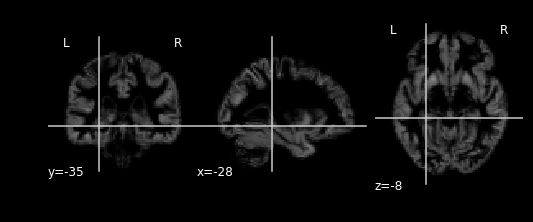

(91, 109, 91)

In [109]:
# Plot one as an example
jnk = ni.load(scans[0])
plt.close()
plotting.plot_anat(jnk, cut_coords=(-28,-35,-8))
plt.show()
jnk.shape

In [110]:
# Load all data into a 4D image
gmvs = image.load_img(scans)
gmvs.shape

(91, 109, 91, 153)

In [111]:
i4d = gmvs.get_data()

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


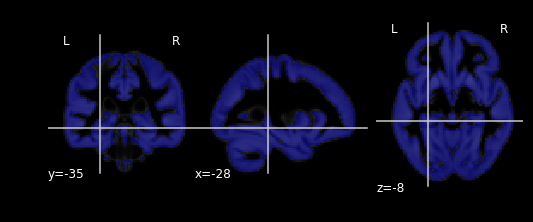

In [112]:
# Make a gray mater mask

avg_image = i4d.mean(3)
mask = np.zeros_like(avg_image)
mask[avg_image>0.2] = 1

plt.close()
plotting.plot_roi(ni.Nifti1Image(mask,gmvs.affine),
                  bg_img = ni.Nifti1Image(avg_image,gmvs.affine),
                  cut_coords=(-28,-35,-8))
plt.show()

In [51]:
# Run structural connectivity anlysis
outdir = wdir
out_imgs = structural_connectivity_analysis(gmvs, df, 'position_along_hipp_AP_axis', 108, 94, 2, outdir)

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


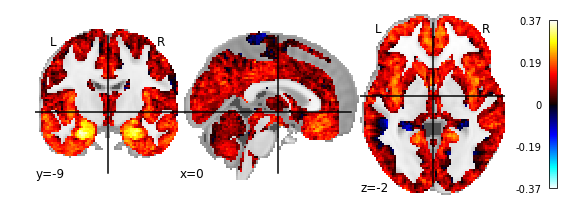

In [78]:
scx = ni.load(os.path.join(wdir, 'strucx_difference.nii'))
plt.close()
plotting.plot_stat_map(scx)
plt.show()

This map seems quite a bit to favor the anterior hippocampus. Perhaps it will be more interpretable if we z-score it?

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


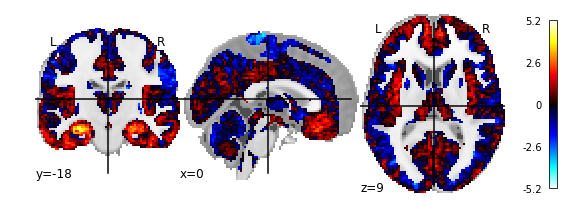

In [113]:
# create mask object only including values inside brain
mskr = input_data.NiftiMasker(ni.Nifti1Image(mask,scx.affine)) 
scxdat = mskr.fit_transform(scx) # mask

# zscore
szdat = (scxdat - scxdat.mean()) / scxdat.std(ddof=1)

# bring back into image space
scxz = mskr.inverse_transform(szdat)

# plot
plt.close()
plotting.plot_stat_map(scxz)
plt.show()

That looks better! Let's save this image

In [116]:
scxz.to_filename(os.path.join(wdir,'strucx_z_difference'))

Let's real quick take a look at the association with HAGGIS (need to move mask into the correct space [2mm])

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


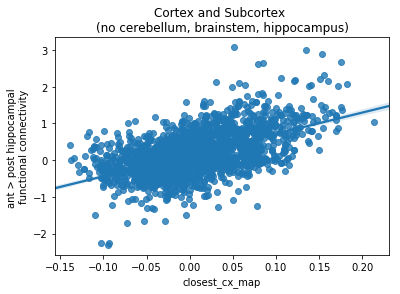

standard statistics: r2 = 0.2974205960720635, p = 3.827939448540778e-150


In [117]:
mni2 = os.path.join(wdir, 'MNI152_T1_2mm_brain.nii.gz')
msk2mm = image.resample_to_img(ni.Nifti1Image(msk3, ni.load(mni).affine),
                               mni2,
                               interpolation='nearest').get_data()
vrad = 3
vdim = 2
res = hap.run_gvfcx_analysis(scxz.get_data(), gdf, msk2mm, vrad, vdim, gcx_col, plabs, 
                               bootstrap=False, n_iter=10, hue_vals=[], illustrative=True)

#### Everything is in different space -- fmri is in 1mm, FDG is in 1.5mm and strucx is in 2mm. Let's put everything into the same space and compare

# Get all cx vectors --> summaries in the same space
Here, we will get all of the images in one space (2mm) so we can compare them more effectively.

In [249]:
mni2mm = ni.load(os.path.join(wdir,'MNI152_T1_2mm_brain.nii.gz'))
f_diff = ni.load(os.path.join(wdir,'cnx_diff_img.nii'))
d_diff = ni.load(os.path.join(fdg_dir,'AD-FTD_globalnorm2.nii.gz'))
s_diff = ni.load(os.path.join(wdir,'strucx_z_difference.nii'))
#dme_s = ni.load('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/Diffusion_Map_Embedding/DME_STRUCT_CTX_Gradient0.nii')
#dme_f = ni.load('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/Diffusion_Map_Embedding/DME_FUNC_CTX_Gradient2.nii')
HO = ni.load(os.path.join(wdir,'HarvardOxford-sub-maxprob-thr25-1mm.nii.gz'))
dkt = ni.load(os.path.join(wdir,'dkt_atlas_1mm.nii.gz'))
diffs = {'fmri':f_diff, 'dis': d_diff, 'struc': s_diff,
#        'dme_s': dme_s, 'dme_f': dme_f
         'dkt': dkt, 'HO': HO
        }

diffs_2mm = {}
for lab,diff in diffs.items():
    print(lab,diff.shape)
    if lab == 'HO' or lab == 'dkt':
        nimg = image.resample_to_img(diff, mni2mm, interpolation='nearest')
    else:
        nimg = image.resample_to_img(diff, mni2mm)
    print('new shape', nimg.shape)
    diffs_2mm.update({lab: nimg})



fmri (182, 218, 182)
new shape (91, 109, 91)
dis (121, 145, 121)
new shape (91, 109, 91)
struc (91, 109, 91, 1)
new shape (91, 109, 91, 1)
dkt (182, 218, 182)
new shape (91, 109, 91)
HO (182, 218, 182)
new shape (91, 109, 91)


In [246]:
plotting.view_img(ni.Nifti1Image(msk4,mni2mm.affine))

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


In [250]:
dkt2 = diffs_2mm['dkt'].get_data()
HO2mm = diffs_2mm['HO'].get_data()
msk1 = np.array(HO2mm,copy=True)
msk1[HO2mm<1] = 0
#no cereb or brainstem
msk2 = np.array(dkt2, copy=True)
msk2[msk2>78] = 0
msk2 = np.array(dkt2, copy=True)
msk2[msk2>78] = 0

# no cereb, brainstem or hippocampus
msk3 = np.array(msk2, copy=True)
msk3[dkt2==36] = 0
msk3[dkt2==75] = 0

# cortex only (no subcortex)
msk4 = np.array(msk3, copy=True)
msk4[dkt2>31] = 0
msk4[dkt2>41] = dkt2[dkt2>41]
msk4[dkt2>70] = 0

In [354]:
vectors = {}

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


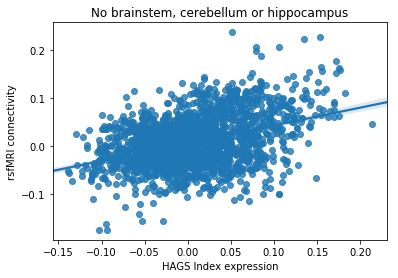

standard statistics: r2 = 0.15563286908678622, p = 5.815220183081284e-73


In [355]:
# functional & genetic

img = diffs_2mm['fmri'].get_data()
vrad=3
vdim = 2
gcx_col='AP_axis_gxp_signature_similarity_SPCR'
bootstrap = False
plabs = ['No brainstem, cerebellum or hippocampus',
         'HAGS Index expression','rsfMRI connectivity']
res, vex = hap.run_gvfcx_analysis(img, gdf, msk3, vrad, vdim, gcx_col, plabs, 
                       bootstrap, n_iter=10, hue_vals=[], illustrative=True)
vectors.update({'gcx': vex['g_vector'], 'fcx': vex['cx_vector']})

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


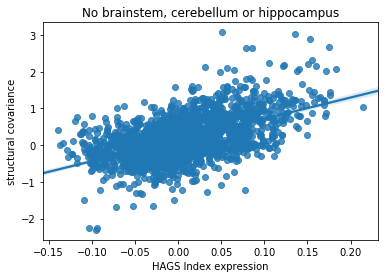

standard statistics: r2 = 0.2974205960720635, p = 3.827939448540778e-150


In [356]:
# structural

img = diffs_2mm['struc'].get_data()
vrad=3
vdim = 2
gcx_col='AP_axis_gxp_signature_similarity_SPCR'
bootstrap = False
plabs = ['No brainstem, cerebellum or hippocampus',
         'HAGS Index expression','structural covariance']
res, vex = hap.run_gvfcx_analysis(img, gdf, msk3, vrad, vdim, gcx_col, plabs, 
                       bootstrap, n_iter=10, hue_vals=[], illustrative=True)
vectors.update({'scx': vex['cx_vector']})

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


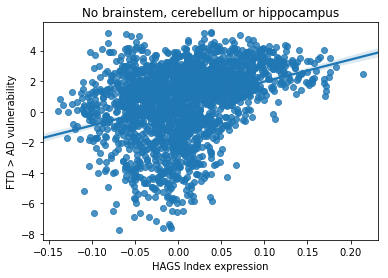

standard statistics: r2 = 0.11250092749634108, p = 5.17371598348766e-52


In [357]:
# disease

img = diffs_2mm['dis'].get_data()
vrad=3
vdim = 2
gcx_col='AP_axis_gxp_signature_similarity_SPCR'
bootstrap = False
plabs = ['No brainstem, cerebellum or hippocampus',
         'HAGS Index expression','FTD > AD vulnerability']
res, vex = hap.run_gvfcx_analysis(img, gdf, msk3, vrad, vdim, gcx_col, plabs, 
                       bootstrap, n_iter=10, hue_vals=[], illustrative=True)
vectors.update({'dcx': vex['cx_vector']})

In [128]:
all_vex = pandas.DataFrame.from_dict(vectors)
all_vex.head()

dcx       fcx       gcx       scx
0  1.936761 -0.017510  0.017612  0.500187
1  3.481936  0.030284 -0.048591  0.670868
2  3.063823  0.028169 -0.001852  0.744531
3  2.084073  0.031734 -0.024976  0.308254
4  2.733630 -0.000567 -0.006868  0.828310

#### Let's prepare the figures for the manuscript

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


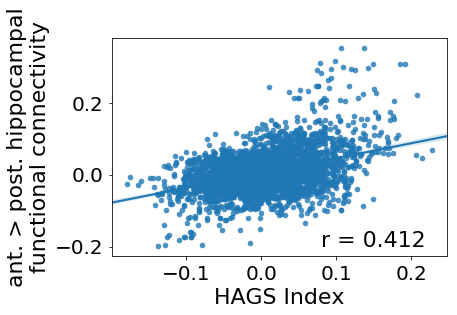

In [119]:
g_cx = all_vex.gcx.values
f_cx = all_vex.fcx.values
plt.close()
sns.set_context('paper', font_scale=2.5)
sns.regplot(g_cx, f_cx)
#plt.title(plabs[0])a
plt.xlabel('HAGS Index')
plt.ylabel('ant. > post. hippocampal\nfunctional connectivity')
#r2 = stats.pearsonr(g_cx,f_cx)[0]**2
#plt.text(0.08, -0.20,'r$^2$ = %s'%float('%.3g'%r2), fontsize=22)
r = stats.pearsonr(g_cx,f_cx)[0]
plt.text(0.08, -0.20,'r = %s'%float('%.3g'%r), fontsize=22)
#plt.savefig(os.path.join(fig_dir,'rsfmri_HAGS_Msk1_r.pdf'),
#           bbox_inches = 'tight')
plt.show()

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


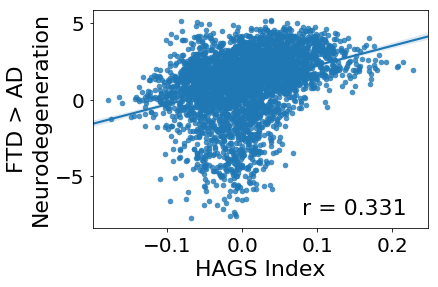

In [120]:
d_cx = all_vex.dcx.values
plt.close()
sns.set_context('paper', font_scale=2.5)
sns.regplot(g_cx, d_cx)
#plt.title(plabs[0])
plt.xlabel('HAGS Index')
plt.ylabel('FTD > AD\nNeurodegeneration')
# r2 = stats.pearsonr(g_cx, d_cx)[0]**2
# plt.text(0.08, -7.5,'r$^2$ = %s'%float('%.3g'%r2), fontsize=22)
r = stats.pearsonr(g_cx,d_cx)[0]
plt.text(0.08, -7.5,'r = %s'%float('%.3g'%r), fontsize=22)
#plt.savefig(os.path.join(fig_dir,'FDG_HAGS_Msk1_r.pdf'),
#            bbox_inches = 'tight')
plt.show()


/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


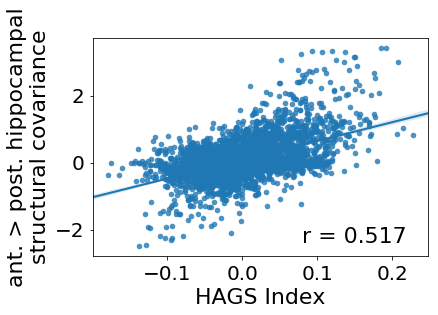

In [121]:
s_cx = all_vex.scx.values
plt.close()
sns.set_context('paper', font_scale=2.5)
sns.regplot(g_cx, s_cx)
#plt.title(plabs[0])
plt.xlabel('HAGS Index')
plt.ylabel('ant. > post. hippocampal\nstructural covariance')
# r2 = stats.pearsonr(g_cx, s_cx)[0]**2
# plt.text(0.08, -2.4,'r$^2$ = %s'%float('%.3g'%r2), fontsize=22)
r = stats.pearsonr(g_cx,s_cx)[0]
plt.text(0.08, -2.4,'r = %s'%float('%.3g'%r), fontsize=22)
#plt.savefig(os.path.join(fig_dir,'scx_HAGS_Msk1_r.pdf'),
#            bbox_inches = 'tight')
plt.show()


## Replicate across different gene sets and masks
Let's see how these relationships change across different gene sets and different brain masks
You will need to have run NB3 for this section to work

#### Gather gene sets

In [140]:
xpdfs = sorted(glob(os.path.join(wdir,'GSET*')))
Gvecs = {}
for sheet in xpdfs:
    label = sheet.split('/')[-1].split('GSET_')[-1].split('_gxp')[0]
    xpdf = pandas.read_csv(sheet, index_col=0)
    if 'top_100_gxp' not in sheet:
        mod = hap.PCA_LR_pipeline(xpdf.T, df.position_along_hipp_AP_axis, 
                               cv_strategy='score', illustrative=False, 
                                sanity_check_style ='model')
    else:
        mod = hap.PCA_LR_pipeline(xpdf.T, df.position_along_hipp_AP_axis, pca=None,
                            clf = linear_model.LassoCV(cv=10, max_iter=5000),
                            cv_strategy='score', illustrative=False,
                            sanity_check_style='model')
    vec = hap.get_gene_vector(bigdf,probe_ids=xpdf.index, betas=mod['betas'])
    Gvecs.update({label: vec})

running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.7892906662272527
running final model
final model fit r2 =  0.8498231362275879
running sanity_check
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.8019898801123544
running final model
final model fit r2 =  0.9121037684478059
running sanity_check
running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.7069095146629301
running final model
final model fit r2 =  0.8301649965373138
running sanity_check
running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


model cv score: r2 =  0.08637398550898778
running final model
final model fit r2 =  0.0
running sanity_check


/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.8295617263968724
running final model
final model fit r2 =  0.8826678229276973
running sanity_check


In [160]:
# combinatorial sets:

set1 = pandas.read_csv(os.path.join(wdir,'GSET_top_100_gxp.csv'),index_col=0)
set2 = pandas.read_csv(os.path.join(wdir,'GSET_top_100_600_gxp.csv'),index_col=0)
set3 = pandas.read_csv(os.path.join(wdir,'GSET_top_600_2700_gxp.csv'),index_col=0)

# top 600
top600 = pandas.concat([set1,set2])
mod = hap.PCA_LR_pipeline(top600.T, df.position_along_hipp_AP_axis, 
                            cv_strategy='score', illustrative=False, 
                            sanity_check_style ='model')
vec = hap.get_gene_vector(bigdf,probe_ids=top600.index, betas=mod['betas'])
Gvecs.update({'top_600': vec})

# top 2700
top2700 = pandas.concat([set1,set2, set3])
mod = hap.PCA_LR_pipeline(top2700.T, df.position_along_hipp_AP_axis, 
                            cv_strategy='score', illustrative=False, 
                            sanity_check_style ='model')
vec = hap.get_gene_vector(bigdf,probe_ids=top2700.index, betas=mod['betas'])
Gvecs.update({'top_2700': vec})

running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.812277828180187
running final model
final model fit r2 =  0.8649413018796686
running sanity_check
running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.8137549097565435
running final model
final model fit r2 =  0.8628223344195239
running sanity_check


#### Run analyses

In [168]:
msks = {'Whole brain': msk1, 'No Cereb/Brainstem': msk2, 
        'No Hippocampus': msk3, 'Cortex only': msk4}
imods = ['fmri','dis','struc']
gset_res = pandas.DataFrame(index = range(len(imods) * len(msks.keys()) * len(Gvecs.keys())),
                            columns = ['modality', 'mask', 'gene_set', 'r2'])
gcx_col='gvec'
vrad = 3
vdim = 2
bootstrap = False
plabs = ['HAGS v Imaging', 'HAGS', 'Imaging']
i=0
for imod in imods:
    img = diffs_2mm[imod].get_data()
    for glab, gset in Gvecs.items():
        if gset == 'all':
            gdf.loc[:,'gvec'] = gdf.AP_axis_gxp_signature_similarity_SPCR.values
        else:
            gdf.loc[:,'gvec'] = gset
        for mlab, msk in msks.items():
            res, vex = hap.run_gvfcx_analysis(img, gdf, msk, vrad, vdim, gcx_col, plabs, 
                       bootstrap, n_iter=10, hue_vals=[], illustrative=False)
            gset_res.loc[i,'modality'] = imod
            gset_res.loc[i,'gene_set'] = glab
            gset_res.loc[i,'mask'] = mlab
            gset_res.loc[i,'r2'] = res['r2'].values[0]
            i += 1
    print('finished',imod)

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  from ipykernel import kernelapp as app


standard statistics: r2 = 0.2066351986366418, p = 9.04720423821547e-162
standard statistics: r2 = 0.19592823683272012, p = 4.652766683434297e-160
standard statistics: r2 = 0.11888587046825587, p = 2.838710478234606e-88
standard statistics: r2 = 0.1035807327747098, p = 3.3135308573720655e-65
standard statistics: r2 = 0.24461802993756068, p = 1.2789521226194225e-195
standard statistics: r2 = 0.23597195722008243, p = 4.521536619526206e-197
standard statistics: r2 = 0.17516825622016963, p = 2.7171990394965012e-133
standard statistics: r2 = 0.13777985928892877, p = 9.795076127124839e-88
standard statistics: r2 = 0.11983077928647312, p = 4.338533658160749e-90
standard statistics: r2 = 0.10386708664592506, p = 1.818806721871038e-81
standard statistics: r2 = 0.04868108785583719, p = 6.81791572206794e-36
standard statistics: r2 = 0.05819607903716053, p = 1.485482477477215e-36


/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


standard statistics: r2 = nan, p = 1.0
standard statistics: r2 = nan, p = 1.0
standard statistics: r2 = nan, p = 1.0
standard statistics: r2 = nan, p = 1.0
standard statistics: r2 = 0.15213401194864584, p = 6.524076772440896e-116
standard statistics: r2 = 0.14185936653468587, p = 6.901780262791424e-113
standard statistics: r2 = 0.08167933967013408, p = 4.895977892522958e-60
standard statistics: r2 = 0.0726809942810967, p = 1.4841397179778826e-45
standard statistics: r2 = 0.24355103828033056, p = 1.2040882032157252e-194
standard statistics: r2 = 0.23305322774233264, p = 2.6156559614742834e-194
standard statistics: r2 = 0.15559846248803968, p = 2.6461690435505823e-117
standard statistics: r2 = 0.1336014152442989, p = 6.167196128791794e-85
standard statistics: r2 = 0.21866570858316753, p = 2.5873880455942393e-172
standard statistics: r2 = 0.20703581386523226, p = 3.873015483450768e-170
standard statistics: r2 = 0.13203774219455727, p = 1.5581178971924444e-98
standard statistics: r2 = 0.11

#### Plot

In [169]:
nkey = {'top_100': 'Set 1', 'top_100_600': 'Set 2', 'top_600': 'Sets 1,2', 
        'top_600_2700': 'Set 3', 'top_2700': 'Sets 1,2,3', 'all': 'All 58k' }
gset_res.loc[:,'gene_set'] = [nkey[x] if x in nkey.keys() else 'out_%s'%x for x in gset_res.gene_set.values]

In [171]:
nkey = {'fmri': 'FC', 'struc': 'SC', 'dis': 'Disease'}
gset_res.loc[:,'modality'] = [nkey[x] for x in gset_res.modality]
gset_res.columns = ['analysis' if x == 'modality' else x for x in gset_res.columns]

In [260]:
#gset_res.to_csv(os.path.join(wdir,'MAIN_geneset_v_img_modality.csv'))

In [174]:
sorted(to_show)

['Set 1', 'Set 2', 'Set 3', 'Sets 1,2', 'Sets 1,2,3']

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


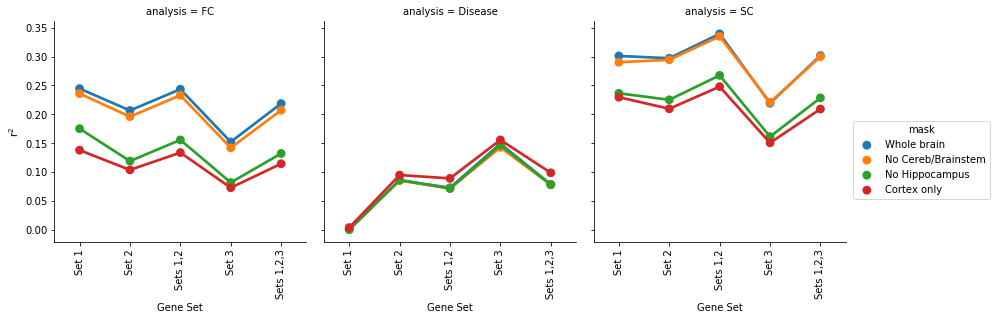

In [176]:
to_show = [x for x in gset_res.gene_set.unique() if 'out_' not in x]
order = ['Set 1', 'Set 2','Sets 1,2','Set 3','Sets 1,2,3']

plt.close()
g = sns.factorplot(x = 'gene_set', y = 'r2', hue = 'mask', col = 'analysis', order=order,
                   data = gset_res[gset_res.gene_set.isin(to_show)])
g.set_xticklabels(rotation = 90)
g.set_xlabels('Gene Set')
g.set_ylabels('r$^2$')
#g.savefig(os.path.join(fig_dir,'GeneSet_v_imaging.pdf'), bbox_inches='tight')
plt.show()

# GENOMIC VARIANCE EXPLAINED + GENOMIC OVERLAP

In this section, we will run a series of models where we will fit models to the maps we have analyzed previously (FDG, function connectivity and structural covariance). Here, we will be trying to learn as much of the variance as we can about these hippocampus-centric brain maps using only genomic information. This will help us produce two analyses:
* 1) We can figure out the maximal genomic variance explainable given the data we have. This can be used to compare to the associations with HAGGIS, to put the explained variance from the HAGGIS into context. For example, perhaps HAGGIS is explaining 20% of the variance in connectivity to the hippocampus. However, if we find out that only 40% of the variance is even explainable using genomic information (the other variance would be noise and non-genomic factors), we know then that HAGGIS is actually explaining 50% of the genomic explainable variance, a much more impressive feat.
* 2) We can learn which genomic features are most important for explaining functional connectivity, structural covariance, and disease vulnerability. We can then compare these features to the most important HAGGIS features. Overlap will help identify which genomic features of HAGGIS are involved in coordinating functional connectivity, structural covariance, and disease vulnerability

## Functional

#### Maximal genomic explained variance
First, we need to fit a model learning differential functional connectivity to the hippocampus using genomic information. 

In [262]:
mod_HIPP = hap.PCA_LR_pipeline(xp.values.T, 
                            (df.position_along_hipp_AP_axis), 
                            cv_strategy='score', illustrative=False,
                           test_gene_num = [100],
                               sanity_check_style = 'separate') # ORIGINAL HAGGIS MODEL


running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.675885977482217
running final model
final model fit r2 =  0.8768105093258057
running sanity_check


In [409]:
# Reduce whole-brain genomic data with PCA
big_pca = PCA(n_components=170,random_state=123).fit(bigdf.T)
big_tfm = pandas.DataFrame(big_pca.transform(bigdf.T))
big_hCM = pandas.DataFrame(big_pca.components_)

In [410]:
# find samples falling within mask
gmsk = np.array(msk3, copy=True)
gmsk[gmsk>0] = 1
hits = []

for i,row in gdf.iterrows():
    coords = hap.convert_coords([row['mni_nlin_x'], 
                                 row['mni_nlin_y'], 
                                 row['mni_nlin_z']], 
                                'xyz', vs=2)
    coords = tuple([int(round(x)) for x in coords])
    if gmsk[coords] == 1:
        hits.append(i)
    

In [412]:
# Fit model to a - p hippocampal functional connectivity
# search across 1-10 components and across different estimators

ncs = 10
nc_chooser = pandas.DataFrame(index = range(ncs*3), columns = ['nc', 'estimator', 'r2','mae'])
i=0
for k,nc in enumerate(range(1,ncs+1)):
    print(nc)
    estimators = {'PLSR': PLSRegression(n_components=nc), 
                  'CCA': CCA(n_components=nc),
                 'PLSC': PLSCanonical(n_components=nc)}
    nc_chooser.loc[k*3:k*3+2,'nc'] = [nc]*3
    for lab, estimator in estimators.items():
        pred = cross_val_predict(estimator, big_tfm3.loc[hits].values, vectors['fcx'], cv=10)
        nc_chooser.loc[i, 'r2'] = stats.pearsonr(vectors['fcx'], pred[:,0])[0]**2
        nc_chooser.loc[i, 'mae'] = mean_absolute_error(y_true=vectors['fcx'], y_pred=pred)
        nc_chooser.loc[i, 'estimator'] = lab
        i+=1

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


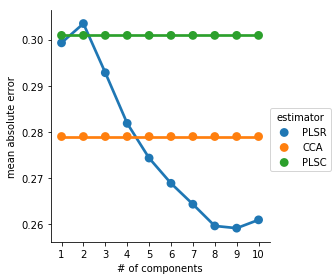

max explainable variance = 0.3034954009184185


In [413]:
# figure out max explainable variance
sns.factorplot(x = 'nc', y='r2', hue = 'estimator', data=nc_chooser)
plt.ylabel('mean absolute error')
plt.xlabel('# of components')
plt.show()
print('max explainable variance = %s'%nc_chooser.r2.max())

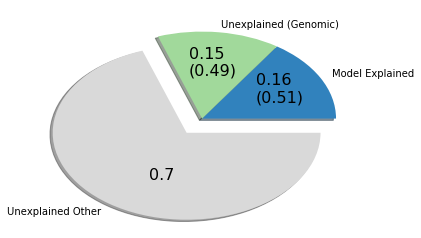

In [323]:
# Plot proportions of variance

a = 0.155632 # from HAGGIS v fmri (msk3)
b = 0.303495 - a # from previous cell
c = 1 - (a+b)
xpl_var = [a,b,c]
labels = ['Model Explained','Unexplained (Genomic)', 'Unexplained Other']
plt.close()
plt.pie(xpl_var, labels=labels, shadow=True, explode=[0.0,0.0,0.2],
       colors= np.array(cm.get_cmap('tab20c').colors)[[0,10,19],:])
plt.text(0.4,0.2,'%s\n(%s)'%(round(a,2),
                             round((a/(a+b)),2)),fontsize=16)
plt.text(-0.1,0.5,'%s\n(%s)'%(round(b,2),
                             round((b/(a+b)),2)),fontsize=16)
plt.text(-0.4,-0.7,round(c,2),fontsize=16)
#plt.savefig(os.path.join(fig_dir,'PIE_Func.pdf'), bbox_inches='tight')
plt.show()

#### Genomic overlap with HAGGIS

In [414]:
# Extract probe-level features from the best fitting model
pls_mod = PLSRegression(n_components=2)
pls_mod.fit(big_tfm.loc[hits].values,vectors['fcx'])
pls_betas = np.dot(big_hCM.values.T, pls_mod.coef_)

In [415]:
# Get top features (anterior and posterior) of HAGGIS model
hipp_res = pandas.concat([pandas.Series(mod_HIPP['betas']),
                          probes.gene_symbol,
                         probes.gene_name], axis=1)
hipp_res.sort_values(0).head()

0  gene_symbol                               gene_name
32889 -0.014675         NPNT                            nephronectin
32888 -0.014107         NPNT                            nephronectin
6582  -0.012919          TTR                           transthyretin
51664 -0.012902  A_32_P11262  AGILENT probe A_32_P11262 (non-RefSeq)
44200 -0.012402       BDKRB1                  bradykinin receptor B1

In [416]:
# Get top features of functional (PLS) model
func_res = pandas.concat([pandas.Series(pls_betas[:,0]),
                          probes.gene_symbol,
                         probes.gene_name], axis=1)
func_res.sort_values(0, ascending=False, inplace=True)
func_res.loc[:,'A-P_order'] = range(len(func_res))
func_res.sort_values(0, ascending=True, inplace=True)
func_res.loc[:,'P-A_order'] = range(len(func_res))

In [417]:
# Show probes that show up in the top 50 anterior features of both models
fcx_ant = []
for probe in hipp_res.sort_values(0, ascending=False).index[:50]:
    PArank = func_res.loc[probe,'P-A_order']
    APrank = func_res.loc[probe,'A-P_order']
    if APrank < 50:
        print('ANTERIOR:', APrank, hipp_res.loc[probe,'gene_symbol'])
        fcx_ant.append(hipp_res.loc[probe,'gene_symbol'])
    if PArank < 50:
        print('POSTERIOR:', PArank, hipp_res.loc[probe,'gene_symbol'])

ANTERIOR: 3 KLK7
ANTERIOR: 21 KLK7
ANTERIOR: 27 PYDC1
ANTERIOR: 12 KCNG1
ANTERIOR: 29 MYB
ANTERIOR: 43 GDA
ANTERIOR: 10 C20orf103
ANTERIOR: 9 SYTL1
ANTERIOR: 39 SEMA3D


In [418]:
# Show probes that show up in the top 50 posterior features of both models
fcx_post = []
for probe in hipp_res.sort_values(0, ascending=True).index[:50]:
    PArank = func_res.loc[probe,'P-A_order']
    APrank = func_res.loc[probe,'A-P_order']
    if APrank < 50:
        print('ANTERIOR:', APrank, hipp_res.loc[probe,'gene_symbol'])
    if PArank < 50:
        print('POSTERIOR:', PArank, hipp_res.loc[probe,'gene_symbol'])
        fcx_post.append(hipp_res.loc[probe,'gene_symbol'])

POSTERIOR: 0 TTR
POSTERIOR: 8 ONECUT2
POSTERIOR: 43 TNNT2
POSTERIOR: 2 TTR
POSTERIOR: 35 HPSE2
POSTERIOR: 5 PVALB
POSTERIOR: 1 CTXN3
POSTERIOR: 34 HPSE2
POSTERIOR: 12 GAL
POSTERIOR: 11 ONECUT2
POSTERIOR: 7 GAL


Make sure this isn't happening by chance

In [350]:
# For 1000 iterations: select 100 random probes and see the likelihood they are in the top 50
# features of the functional model
n100_phits = []
n100_ahits = []
for i in range(1000):
    randind = np.random.choice(hipp_res.index, 100)
    ahits = []
    phits = []
    for probe in randind:
        PArank = func_res.loc[probe,'P-A_order']
        APrank = func_res.loc[probe,'A-P_order']
        if APrank < 50:
            ahits.append(probe)
        if PArank < 50:
            phits.append(probe)
    n100_phits.append(len(phits))
    n100_ahits.append(len(ahits))

In [351]:
# anterior features
jnk = np.array(n100_ahits)
1 - len(jnk[jnk<17]) / (1000+1) # pvalue (minimum is 0.001)

0.0009990009990009652

In [352]:
# posterior features
jnk = np.array(n100_phits)
1 - len(jnk[jnk<8]) / (1000+1)  # pvalue (minimum is 0.001)

0.0009990009990009652

## Structural

#### Maximal genomic explained variance

In [420]:
ncs = 10
nc_chooser = pandas.DataFrame(index = range(ncs*3), columns = ['nc', 'estimator', 'r2','mae'])
i=0
for k,nc in enumerate(range(1,ncs+1)):
    print(nc)
    estimators = {'PLSR': PLSRegression(n_components=nc), 
                  'CCA': CCA(n_components=nc),
                 'PLSC': PLSCanonical(n_components=nc)}
    nc_chooser.loc[k*3:k*3+2,'nc'] = [nc]*3
    for lab, estimator in estimators.items():
        pred = cross_val_predict(estimator, big_tfm.loc[hits].values, vectors['scx'], cv=10)
        nc_chooser.loc[i, 'r2'] = stats.pearsonr(vectors['scx'], pred[:,0])[0]**2
        nc_chooser.loc[i, 'mae'] = mean_absolute_error(y_true=vectors['scx'], y_pred=pred)
        nc_chooser.loc[i, 'estimator'] = lab
        i+=1

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


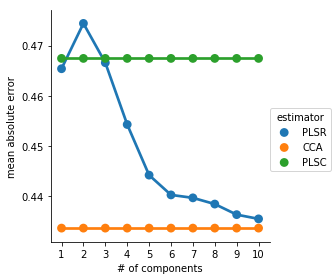

max explainable variance = 0.47441286152870094


In [421]:
# figure out max explainable variance
sns.factorplot(x = 'nc', y='r2', hue = 'estimator', data=nc_chooser)
plt.ylabel('mean absolute error')
plt.xlabel('# of components')
plt.show()
print('max explainable variance = %s'%nc_chooser.r2.max())

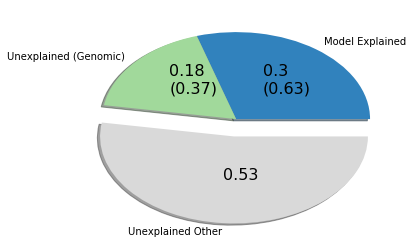

In [422]:
a = 0.29742 # from HAGGIS v structural cov (msk3)
b = 0.47441 - a # from previous cell
c = 1 - (a+b)
xpl_var = [a,b,c]
labels = ['Model Explained','Unexplained (Genomic)', 'Unexplained Other']
plt.close()
plt.pie(xpl_var, labels=labels, shadow=True, explode=[0.0,0.0,0.2],
       colors= np.array(cm.get_cmap('tab20c').colors)[[0,10,19],:])
plt.text(0.2,0.3,'%s\n(%s)'%(round(a,2),
                             round((a/(a+b)),2)), fontsize=16)
plt.text(-0.5,0.3,'%s\n(%s)'%(round(b,2),
                             round((b/(a+b)),2)),fontsize=16)
plt.text(-0.1,-0.7,round(c,2),fontsize=16)
#plt.savefig(os.path.join(fig_dir,'PIE_Struct.pdf'),bbox_inches='tight')
plt.show()

#### Genomic overlap with HAGGIS

In [423]:
pls_mod = PLSRegression(n_components=2)
pls_mod.fit(big_tfm.loc[hits].values,vectors['scx'])
pls_betas = np.dot(big_hCM.values.T, pls_mod.coef_)

In [424]:
func_res = pandas.concat([pandas.Series(pls_betas[:,0]),
                          probes.gene_symbol,
                         probes.gene_name], axis=1)

In [425]:
func_res.sort_values(0, ascending=False, inplace=True)
func_res.loc[:,'A-P_order'] = range(len(func_res))
func_res.sort_values(0, ascending=True, inplace=True)
func_res.loc[:,'P-A_order'] = range(len(func_res))

In [426]:
scx_ant = []
for probe in hipp_res.sort_values(0, ascending=False).index[:50]:
    PArank = func_res.loc[probe,'P-A_order']
    APrank = func_res.loc[probe,'A-P_order']
    if APrank < 50:
        print('ANTERIOR:', APrank, hipp_res.loc[probe,'gene_symbol'])
        scx_ant.append(hipp_res.loc[probe,'gene_symbol'])
    if PArank < 50:
        print('POSTERIOR:', PArank, hipp_res.loc[probe,'gene_symbol'])

ANTERIOR: 12 KLK7
ANTERIOR: 43 RSPH9
ANTERIOR: 37 KLK7
ANTERIOR: 19 PYDC1
ANTERIOR: 15 TMEM215
ANTERIOR: 5 KCNG1
ANTERIOR: 36 C1orf187
ANTERIOR: 13 SYTL1
ANTERIOR: 21 A_32_P115840


In [427]:
scx_post = []
for probe in hipp_res.sort_values(0, ascending=True).index[:50]:
    PArank = func_res.loc[probe,'P-A_order']
    APrank = func_res.loc[probe,'A-P_order']
    if APrank < 50:
        print('ANTERIOR:', APrank, hipp_res.loc[probe,'gene_symbol'])
    if PArank < 50:
        print('POSTERIOR:', PArank, hipp_res.loc[probe,'gene_symbol'])
        scx_post.append(hipp_res.loc[probe,'gene_symbol'])

POSTERIOR: 0 TTR
POSTERIOR: 4 TPBG
POSTERIOR: 2 ONECUT2
POSTERIOR: 10 COL5A2
POSTERIOR: 30 TNNT2
POSTERIOR: 15 TTR
POSTERIOR: 11 COL5A2
POSTERIOR: 8 PVALB
POSTERIOR: 20 GAL
POSTERIOR: 39 COL5A2
POSTERIOR: 6 ONECUT2
POSTERIOR: 13 GAL


## Disease

#### Maximal genomic explained variance

In [429]:
ncs = 10
nc_chooser = pandas.DataFrame(index = range(ncs*3), columns = ['nc', 'estimator', 'r2','mae'])
i=0
for k,nc in enumerate(range(1,ncs+1)):
    print(nc)
    estimators = {'PLSR': PLSRegression(n_components=nc), 
                  'CCA': CCA(n_components=nc),
                 'PLSC': PLSCanonical(n_components=nc)}
    nc_chooser.loc[k*3:k*3+2,'nc'] = [nc]*3
    for lab, estimator in estimators.items():
        pred = cross_val_predict(estimator, big_tfm.loc[hits].values, vectors['dcx'], cv=10)
        nc_chooser.loc[i, 'r2'] = stats.pearsonr(vectors['dcx'], pred[:,0])[0]**2
        nc_chooser.loc[i, 'mae'] = mean_absolute_error(y_true=vectors['dcx'], y_pred=pred)
        nc_chooser.loc[i, 'estimator'] = lab
        i+=1

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


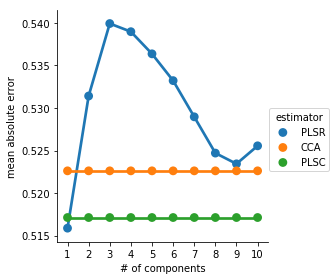

max explainable variance = 0.5399317450802121


In [430]:
# figure out max explainable variance
sns.factorplot(x = 'nc', y='r2', hue = 'estimator', data=nc_chooser)
plt.ylabel('mean absolute error')
plt.xlabel('# of components')
plt.show()
print('max explainable variance = %s'%nc_chooser.r2.max())

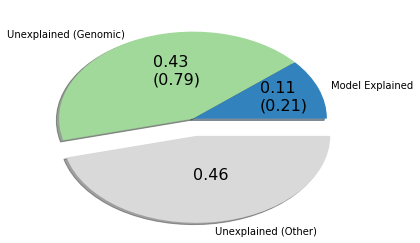

In [432]:
a = 0.11250 # from HAGGIS v disease vulnerability
b = 0.53993 - a # from previous cell
c = 1 - (a+b)
xpl_var = [a,b,c]
labels = ['Model Explained','Unexplained (Genomic)', 'Unexplained (Other)']
plt.close()
plt.pie(xpl_var, labels=labels, shadow=True, explode=[0.0,0.0,0.2],
        colors= np.array(cm.get_cmap('tab20c').colors)[[0,10,19],:])
plt.text(0.5,0.1,'%s\n(%s)'%(round(a,2),
                             round((a/(a+b)),2)), fontsize=16)
plt.text(-0.3,0.4,'%s\n(%s)'%(round(b,2),
                             round((b/(a+b)),2)),fontsize=16)
plt.text(0,-0.7,round(c,2),fontsize=16)
#plt.savefig(os.path.join(fig_dir,'PIE_FDG.pdf'), bbox_inches='tight')
plt.show()

In [433]:
pls_mod = PLSRegression(n_components=4)
pls_mod.fit(big_tfm.loc[hits].values,vectors['dcx'])
pls_betas = np.dot(big_hCM.values.T, pls_mod.coef_)

In [434]:
func_res = pandas.concat([pandas.Series(pls_betas[:,0]),
                          probes.gene_symbol,
                         probes.gene_name], axis=1)

In [435]:
func_res.sort_values(0, ascending=False, inplace=True)
func_res.loc[:,'A-P_order'] = range(len(func_res))
func_res.sort_values(0, ascending=True, inplace=True)
func_res.loc[:,'P-A_order'] = range(len(func_res))

In [436]:
dis_ant = []
for probe in hipp_res.sort_values(0, ascending=False).index[:50]:
    PArank = func_res.loc[probe,'P-A_order']
    APrank = func_res.loc[probe,'A-P_order']
    if APrank < 50:
        print('ANTERIOR:', APrank, hipp_res.loc[probe,'gene_symbol'])
        dis_ant.append(hipp_res.loc[probe,'gene_symbol'])
    if PArank < 50:
        print('POSTERIOR:', PArank, hipp_res.loc[probe,'gene_symbol'])

ANTERIOR: 30 GABRQ
POSTERIOR: 29 C1QL1
ANTERIOR: 7 PIRT
ANTERIOR: 40 OPRK1
ANTERIOR: 6 LGALS2
ANTERIOR: 2 A_32_P115840


In [437]:
dis_post = []
for probe in hipp_res.sort_values(0, ascending=True).index[:50]:
    PArank = func_res.loc[probe,'P-A_order']
    APrank = func_res.loc[probe,'A-P_order']
    if APrank < 50:
        print('ANTERIOR:', APrank, hipp_res.loc[probe,'gene_symbol'])
    if PArank < 50:
        print('POSTERIOR:', PArank, hipp_res.loc[probe,'gene_symbol'])
        dis_post.append(hipp_res.loc[probe,'gene_symbol'])

ANTERIOR: 4 TTR
POSTERIOR: 34 COL5A2
ANTERIOR: 36 TTR
POSTERIOR: 27 COL5A2
POSTERIOR: 40 PVALB


### Summarize genomic overlap with Venn Diagrams

Anterior

In [444]:
# This will take care of a bug in the code
filler_dis = dis_post + [' ']
filler_fcx = fcx_post + [' ']

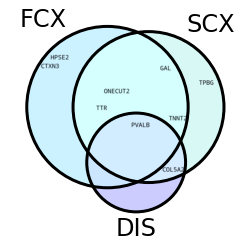

In [446]:
plt.close()
matplotlib_venn_wordcloud.venn3_wordcloud([set(filler_fcx), set(scx_post),set(filler_dis)],
                                         set_labels = ('FCX','SCX','DIS'),
                                         set_colors =['deepskyblue','turquoise','b'],
                                         alpha=0.2)
plt.savefig(os.path.join(fig_dir,'P_Venn.pdf'),
           bbox_inches = 'tight')
plt.show()


Posterior

In [438]:
# Clean up some of the names
scx_ant.remove('A_32_P115840')
scx_ant.append('GABRQ')

dis_ant.remove('A_32_P115840')
dis_ant.append('GABRQ')

In [439]:
filler_dis = dis_ant + [' ']
filler_fcx = fcx_ant + [' ']

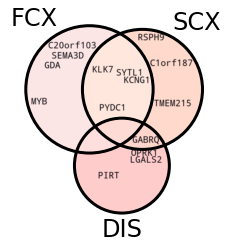

In [440]:
plt.close()
matplotlib_venn_wordcloud.venn3_wordcloud([set(filler_fcx), set(scx_ant),set(filler_dis)],
                                         set_labels = ('FCX','SCX','DIS'),
                                         set_colors =['lightcoral','orangered','r'],
                                         alpha=0.2)
plt.savefig(os.path.join(fig_dir,'A_Venn.pdf'),
           bbox_inches = 'tight')
plt.show()

THINGS TO ADD: 

* Any lingering DME stuff
* Other to-adds (figure and data locations, HAGS, etc)

# Diffusion Embedding: Structural

In [33]:
# ALL COORDINATES FOR DIFFUSION EMBEDDING
i4d = gmvs.get_data()
avg_image = i4d.mean(3)
mask = np.zeros_like(avg_image)
mask_thr = 0.2
mask[avg_image>mask_thr] = 1
mskr = input_data.NiftiMasker(ni.Nifti1Image(mask,gmvs.affine))
i2d = mskr.fit_transform(gmvs)
cdf = df[['mni_nlin_x','mni_nlin_y','mni_nlin_z']]
all_mtx = get_structural_connectivity(cdf, i4d, i2d, vdim=2, embedded=False)

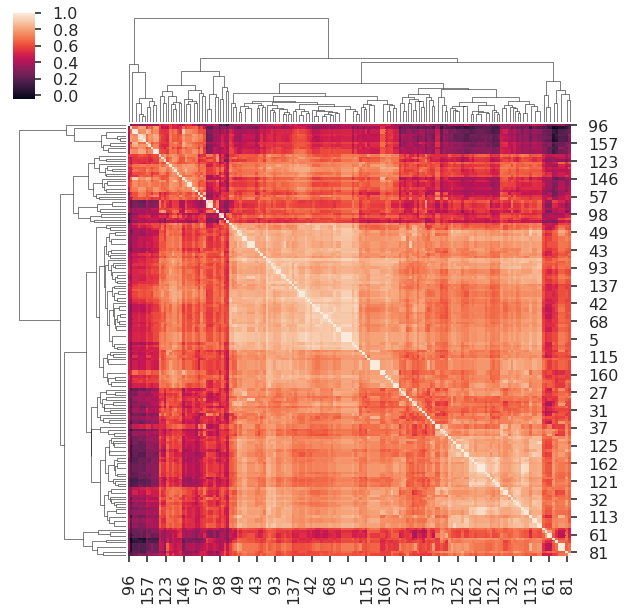

In [143]:
plt.close()
sns.clustermap(jnk)
plt.show()

In [144]:
np.savez_compressed('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_ALL_coords_matrix', all_mtx)

In [6]:
all_mtx = np.load('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_ALL_coords_matrix.npz')['arr_0']

#### VISUALIZE RESULTS OF DIFFUSION EMBEDDING

In [145]:
jnk = {'all_mtx': all_mtx}
savemat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_ALL_coords_matrix',jnk)

In [6]:
emb = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_diff_emb_emb.mat')
res = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_diff_emb_res.mat')

In [57]:
del(all_mtx)

In [58]:
del(gmvs)
del(i4d)
del(i2d)

In [7]:
pca_tfm = pcalr_out_NEW['pca_object'].transform(xp.values.T)
predicted = pcalr_out_NEW['final_model'].predict(pca_tfm)
df.loc[:,'predicted'] = predicted

In [8]:
# VARIANCE EXPLAINED:
lambdas = res['res'][0][0][1]
lambdas / np.sum(lambdas)

array([[0.22396729, 0.14395641, 0.13441753, 0.10896485, 0.07861001,
        0.06185049, 0.05669524, 0.0454259 , 0.04152334, 0.03770886,
        0.03393468, 0.03294539]])

In [9]:
svecs = res['res'][0][0][4]
for i in range(svecs.shape[-1]):
    print(i,stats.pearsonr(df.position_along_hipp_AP_axis, svecs[:,i]))

0 (-6.843036429089219e-05, 0.9992933616050114)
1 (-0.6618368295623529, 8.723749447165814e-23)
2 (0.173577943025643, 0.0235929687507773)
3 (0.029274894606394614, 0.7047153185536786)
4 (-0.1972507530525155, 0.009930442129227017)
5 (-0.16589345048617823, 0.030615763979139104)
6 (-0.18670636449686484, 0.01477412795284198)
7 (0.21740870703572462, 0.004400954851890191)
8 (-0.22910158729275748, 0.0026544569949718696)
9 (0.07729665669249074, 0.31639707023572244)
10 (0.03760419328106904, 0.6263621131001496)
11 (-0.09852864139144457, 0.20114686824337744)
12 (-0.009592176644130482, 0.9011990422302446)


In [10]:
svecs = res['res'][0][0][4]
for i in range(svecs.shape[-1]):
    print(i,stats.pearsonr(df.predicted, svecs[:,i]))

0 (-0.04288758480072692, 0.5786787701147353)
1 (-0.6425489351674218, 3.555532833943468e-21)
2 (0.11972310096982958, 0.11992701546597838)
3 (0.010638504479555281, 0.8904857114293425)
4 (-0.18573276344674836, 0.015311341629481917)
5 (-0.1302638910441913, 0.09043180038625706)
6 (-0.16232542831012178, 0.03443875495970426)
7 (0.22671194361020078, 0.0029494030513440026)
8 (-0.26723436122548055, 0.00042686306707129425)
9 (0.0460475693734612, 0.5509924295159598)
10 (0.05770220764714501, 0.4548118721367108)
11 (-0.09973679074694292, 0.19565043809818783)
12 (0.026405193477227553, 0.732500562749499)


In [12]:
len(svecs[:,1])

170

In [14]:
# Isolate hippocampus
jnk = ni.load('/usr/share/fsl/5.0/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr25-1mm.nii.gz')
atlas = jnk.get_data()
aff = jnk.affine
hipp = np.zeros_like(atlas)
hipp[(atlas==9) | (atlas==19)] = 1
nhipp = ni.Nifti1Image(hipp, aff)
hipp = nhipp.get_data()

# Get voxel mappings
vox = pandas.read_csv(os.path.join(wdir,'MAIN_vox_mapping.csv')).astype(int)


In [34]:
rend_hipp_T = np.zeros_like(hipp)
for i,row in vox.iterrows():
    rend_hipp_T[row['x'],row['y'],row['z']] = ((svecs[:,1])*-1)[row['ind']]

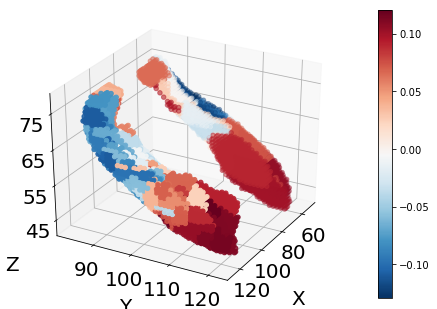

In [35]:
hap.plot_3d_render(np.where(hipp == 1), rend_hipp_T, 
                   outfl = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/Diffusion_Map_Embedding/DME_Struct_HippRender.pdf')

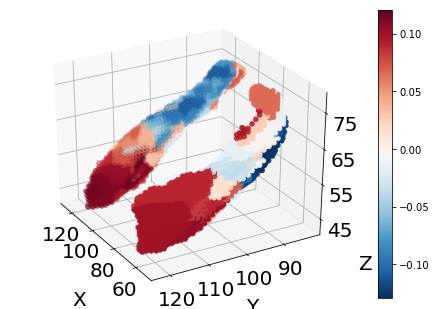

In [36]:
hap.plot_3d_render(np.where(hipp == 1), rend_hipp_T,r1=0, r2=180, step=30,
                  outfl = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/Diffusion_Map_Embedding/DME_Struct_HippRender2.pdf')

In [1089]:
#df.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/MAIN_ALLVAR_hippocampus_sample_info.csv')

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


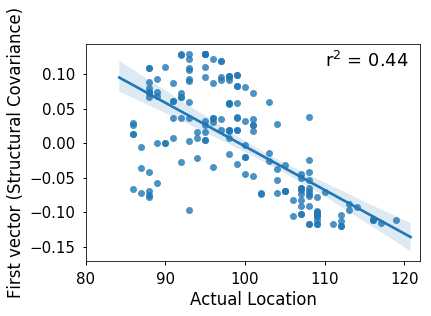

In [65]:
sns.set_context('notebook', font_scale=1.5)

plt.close()
sns.regplot(df.position_along_hipp_AP_axis, svecs[:,1])
plt.xlabel('Actual Location')
plt.ylabel('First vector (Structural Covariance)')
r,p = stats.pearsonr(df.position_along_hipp_AP_axis, svecs[:,1])
plt.text(110,0.11, 'r$^2$ = %s'%round(r**2,2))
plt.xlim(80,122)
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_strucx_actual.pdf',
#           bbox_inches='tight')
plt.show()

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


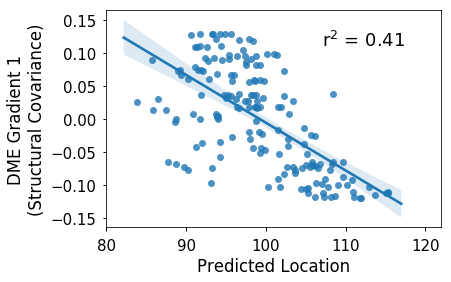

In [69]:
plt.close()
sns.regplot(predicted, svecs[:,1])
plt.xlabel('Predicted Location')
plt.ylabel('DME Gradient 1\n(Structural Covariance)')
r,p = stats.pearsonr(predicted, svecs[:,1])
plt.text(107,0.11, 'r$^2$ = %s'%round(r**2,2))
plt.xlim(80,122)
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_strucx_predicted.pdf',
#           bbox_inches='tight')
plt.show()

In [59]:
emb = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_diff_emb_emb.mat')
res = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_diff_emb_res.mat')
svecsCTX = emb['emb']
#dme_ress = pandas.DataFrame(index=range(fvecsCTX.shape[-1]), columns = ['position_r2','predicted_r2','predicted_p'])
dme_ress = pandas.DataFrame(index=range(svecsCTX.shape[-1]), columns = ['position_r2','predicted_r2','predicted_p'])

# stats
for i in range(svecsCTX.shape[-1]):
    r,p = stats.pearsonr(df.position_along_hipp_AP_axis, svecsCTX[:,i])
    dme_ress.loc[i,'position_r2'] = r**2
    r,p = stats.pearsonr(predicted, svecsCTX[:,i])
    dme_ress.loc[i,'predicted_r2'] = r**2
    dme_ress.loc[i,'predicted_p'] = p

# p-correction
dme_ress.loc[:,'p(corrected)'] = multipletests(dme_ress.predicted_p,method='bonferroni')[1]

# explained variance
lambdas = res['res'][0][0][1][0][:res['res'][0][0][2][0][0]]
dme_ress.loc[:,'Expl. Var of Gradient'] = (lambdas / np.sum(lambdas))

#dme_ress.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_S_table.csv')
dme_ress

ValueError: operands could not be broadcast together with shapes (170,) (332,) 

## Diffusion Embedding: Functional

In [22]:
cx_paths = sorted(glob('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/rsfmri_neurosynth/*'))
cx_coords = []
for i,cx in enumerate(cx_paths):
    cx_X = int(cx.split('_')[-3])
    cx_Y = int(cx.split('_')[-2])
    cx_Z = int(cx.split('_')[-1].split('.')[0])
    cx_coords.append([cx_X, cx_Y, cx_Z])
    

In [73]:
len(cx_coords)

96

In [23]:
coords = df.loc[i,['mni_nlin_x','mni_nlin_y','mni_nlin_z']].values

In [24]:
samp2func_mapping = {}
for i in df.index: 
    coords = df.loc[i,['mni_nlin_x','mni_nlin_y','mni_nlin_z']].values
    dists = []
    for cc in cx_coords:
        dist = sum([abs(cc[0] - coords[0]), 
                    abs(cc[1] - coords[1]), 
                    abs(cc[2] - coords[2])])
        dists.append(dist)
    gind = np.argmin(dists)
    samp2func_mapping.update({i: gind})

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


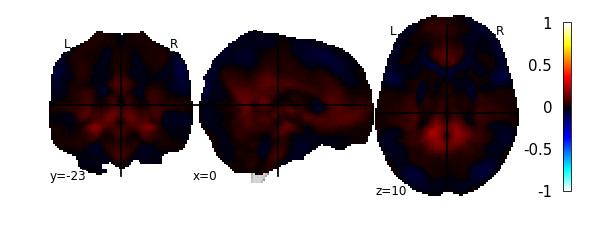

In [77]:
plt.close()
plotting.plot_stat_map(cx_paths[0])
plt.show()

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


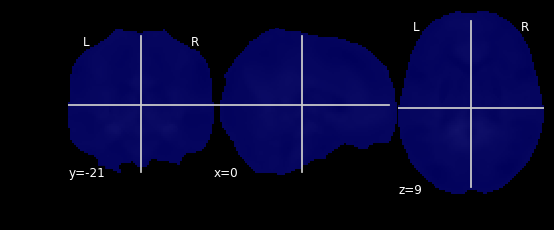

In [78]:
jnk = ni.load(cx_paths[0])
dat = jnk.get_data()
dat[dat!=0] = 1
mask = ni.Nifti1Image(dat, jnk.affine)
plt.close()
plotting.plot_roi(mask,cx_paths[0])
plt.show()

In [79]:
maskr = input_data.NiftiMasker(mask_img=mask)
mjnk = maskr.fit_transform(jnk)
mjnk.shape

(1, 280494)

In [14]:
# MASKS TAKEN FROM GET CX VECTOR SECTION BELOW
mni2mm = ni.load('/usr/share/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz')

mskrs = {}
for i, msk in enumerate([msk1, msk2, msk3, msk4]):
    l = i+1
    arr = np.zeros_like(msk)
    arr[msk.astype(int)>0] = 1
    jnk = ni.Nifti1Image(arr.astype(int), mni2mm.affine)
    mskr = input_data.NiftiMasker(jnk)
    mskrs.update({'msk%s'%l: mskr})

In [55]:
n_feats = len([x for x in mskrs['msk4'].mask_img.get_data().flat>0 if x])
i2d = np.zeros((len(df.index),n_feats))
for samp, pth in samp2func_mapping.items():
    i2d[samp,:] = mskrs['msk4'].fit_transform(cx_paths[pth])[0,:]
    print(samp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169


In [56]:
np.savez_compressed('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/funcx_ALL_coords_matrix_CTX', i2d)
jnk = {'all_mtx': i2d}
savemat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/funcx_ALL_coords_matrix_CTX',jnk)

In [24]:
from statsmodels.sandbox.stats.multicomp import multipletests
emb = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/funcx_diff_CTX_emb_emb.mat')
res = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/funcx_diff_CTX_emb_res.mat')
fvecsCTX = emb['emb']
dme_resf = pandas.DataFrame(index=range(fvecsCTX.shape[-1]), columns = ['position_r2','predicted_r2','predicted_p'])

# stats
for i in range(fvecsCTX.shape[-1]):
    r,p = stats.pearsonr(df.position_along_hipp_AP_axis, fvecsCTX[:,i])
    dme_resf.loc[i,'position_r2'] = r**2
    r,p = stats.pearsonr(predicted, fvecsCTX[:,i])
    dme_resf.loc[i,'predicted_r2'] = r**2
    dme_resf.loc[i,'predicted_p'] = p

# p-correction
dme_resf.loc[:,'p(corrected)'] = multipletests(dme_resf.predicted_p,method='bonferroni')[1]

# explained variance
lambdas = res['res'][0][0][1][0][:res['res'][0][0][2][0][0]]
dme_resf.loc[:,'Expl. Var of Gradient'] = (lambdas / np.sum(lambdas))

dme_resf

position_r2 predicted_r2  predicted_p p(corrected)  Expl. Var of Gradient
0     0.033716    0.0318459    0.0198954     0.198954               0.178543
1     0.207215     0.209002  3.68212e-10  3.68212e-09               0.157541
2     0.459425     0.398209  2.87252e-20  2.87252e-19               0.135064
3    0.0304687     0.015419     0.106674            1               0.118252
4   0.00845761  0.000657191     0.740012            1               0.091784
5    0.0748605    0.0619135   0.00106808    0.0106808               0.086254
6  0.000557226   0.00621349      0.30689            1               0.078544
7   0.00253061  5.46604e-07     0.992366            1               0.063419
8    0.0351465     0.038701    0.0101335     0.101335               0.050019
9    0.0446761    0.0399738   0.00894785    0.0894785               0.040582

In [1131]:
#dme_resf.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_F_table.csv')

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


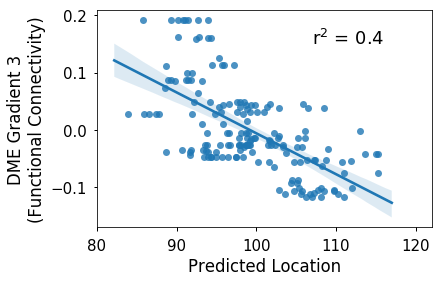

In [110]:
plt.close()
sns.regplot(predicted, fvecsCTX[:,2])
plt.xlabel('Predicted Location')
plt.ylabel('DME Gradient 3\n(Functional Connectivity)')
r,p = stats.pearsonr(predicted, fvecsCTX[:,2])
plt.text(107,0.15, 'r$^2$ = %s'%round(r**2,2))
plt.xlim(80, 122)
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_funcx_predicted_CTX.pdf',
#           bbox_inches='tight')
plt.show()

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


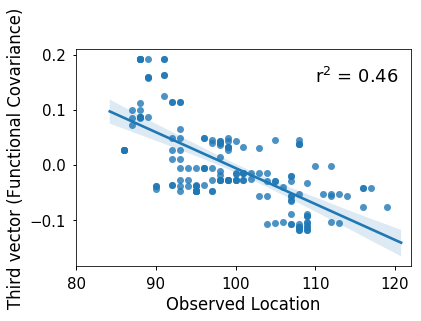

In [111]:
plt.close()
sns.regplot(df.position_along_hipp_AP_axis, fvecsCTX[:,2])
plt.xlabel('Observed Location')
plt.ylabel('Third vector (Functional Covariance)')
r,p = stats.pearsonr(df.position_along_hipp_AP_axis, fvecsCTX[:,2])
plt.text(110,0.15, 'r$^2$ = %s'%round(r**2,2))
plt.xlim(80, 122)
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_funcx_observed_CTX.pdf',
#           bbox_inches='tight')
plt.show()

In [37]:
rend_hipp_T = np.zeros_like(hipp)
for i,row in vox.iterrows():
    rend_hipp_T[row['x'],row['y'],row['z']] = ((fvecsCTX[:,2])*-1)[row['ind']]

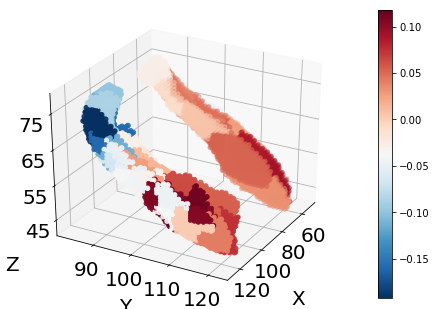

In [38]:
hap.plot_3d_render(np.where(hipp == 1), rend_hipp_T, 
                 outfl = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/Diffusion_Map_Embedding/DME_Func_HippRender.pdf'
                  )

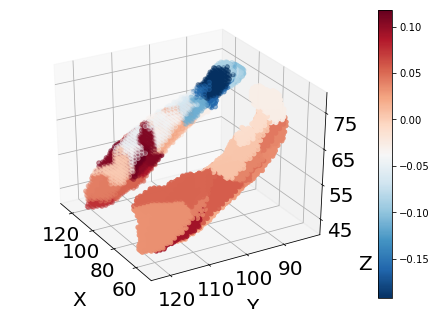

In [39]:
hap.plot_3d_render(np.where(hipp == 1), rend_hipp_T,r1=0, r2=180, step=30,
                  outfl = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/Diffusion_Map_Embedding/DME_Func_HippRender2.pdf'
                  )

# NEED TO PUT IN STUFF HERE

In [120]:
df.loc[:,'Set 1'] = MOD_t100['final_model'].predict(top_100.values.T)
df.loc[:,'Set 2'] = MOD_t100_600['final_model'].predict(PCA_t100_600)
df.loc[:,'Set 1,2'] = MOD_t600['final_model'].predict(PCA_600)
df.loc[:,'Set 3'] = MOD_t600_2700['final_model'].predict(PCA_t600_2700)
df.loc[:,'Set 1,2,3'] = MOD_t2700['final_model'].predict(PCA_t2700)

df.columns = df.columns[:-6].tolist() + ['All 58k','Set 1','Set 2','Set 1,2','Set 3','Set 1,2,3' ]
dme_res = pandas.DataFrame(index = range(2*6),
                           columns = ['modality','set','r2'])
c = 0
gsets = [top_100, top_100_600, top_600, top_600_2700, top_2700]
for l,col in enumerate(df.columns[-6:]):
    if l == 0:
        predicted = df[col].values
    else:
        gset = gsets[l-1]
        if col == 'Set 1':
            pcalr_res = PCA_LR_pipeline(gset.values.T,
                                        (df.position_along_hipp_AP_axis), pca=None,
                                        clf = linear_model.LassoCV(cv=10,max_iter=5000),
                                        cv_strategy='score', illustrative=False,
                                       sanity_check_style = 'model')
            predicted = pcalr_res['final_model'].predict(gset.values.T)
        else:
            pcalr_res = PCA_LR_pipeline(gset.values.T, 
                                        (df.position_along_hipp_AP_axis),
                                        clf = linear_model.LassoCV(cv=10),
                                        cv_strategy='score', illustrative=False,
                                       sanity_check_style = 'model')
            predicted = pcalr_res['final_model'].predict(pcalr_res['pca_object'].transform(gset.values.T))
        df[col] = predicted
    for i,vec in enumerate([svecs, fvecsCTX]):
        if i == 0:
            lab = 'Structural Covariance'
            ind = 1
        else:
            lab = 'Functional Connectivity'
            ind=3
        r,p = stats.pearsonr(df[col], vec[:,ind])
        dme_res.loc[c,'modality'] = lab
        dme_res.loc[c,'set'] = col
        dme_res.loc[c,'r2'] = r**2
        c+=1


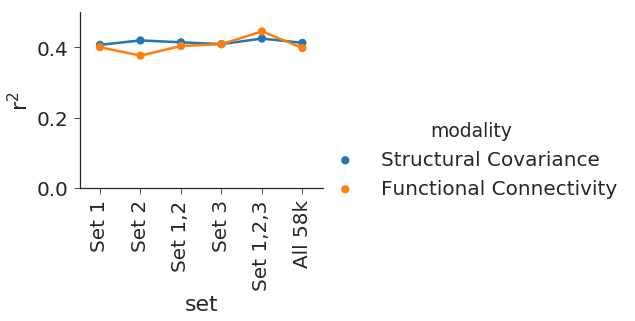

In [522]:
sns.set_context('paper', font_scale=2.5)
plt.close()
g = sns.factorplot(x='set',y='r2',hue='modality',data=dme_res, aspect=1.5,
                   order=['Set 1','Set 2','Set 1,2','Set 3','Set 1,2,3', 'All 58k'])
g.set_xticklabels(rotation=90)
plt.ylabel('r$^2$')
plt.ylim(0,0.5)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_Set_comp.pdf',
           bbox_inches='tight')
plt.show()

### Visualize DME Gradients

#### functional

In [5]:
emb = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/funcx_diff_CTX_emb_emb.mat')
res = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/funcx_diff_CTX_emb_res.mat')

In [62]:
fmtx = np.load('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/funcx_ALL_coords_matrix_CTX.npz'
       )['arr_0']

>>>GRADIENT 2 <<<<


/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


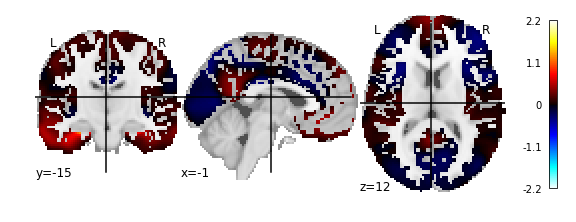

>>>GRADIENT 3 <<<<


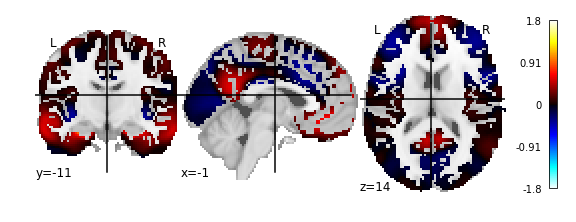

>>>GRADIENT 6 <<<<


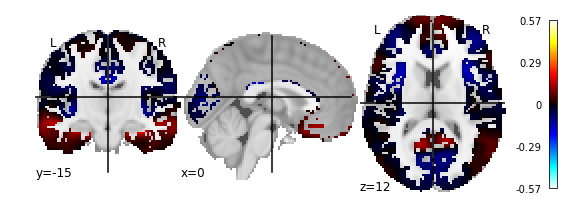

In [79]:
dmskr = mskrs['msk4'].fit(cx_paths[pth]) # initiate mask

for i in range(emb['emb'].shape[-1]): # for each gradient
    # if gradient significantly associqated with genomic gradient
    if dme_resf.loc[i,'p(corrected)'] < 0.05:
        print('>>>GRADIENT %s <<<<'%(i+1))
        dmat = np.dot(fmtx.T, emb['emb'][:,i]) # get voxelwise weights
        dmat = dmat.reshape(1,len(dmat)) # convert to transformable shape
        dmat_i = dmskr.inverse_transform(dmat).get_data() # transform to image spaace
        # reverse the sign of Gradient 3:
        if i == 2:
            dmat_i *= -1
        dmat_i = dmat_i.reshape(dmat_i.shape[:3]) # reshape back to 3D space
        dmat_img = ni.Nifti1Image(dmat_i, affine=mni2mm.affine) # make back into nii object
        # plot
        plt.close()
        plotting.plot_stat_map(dmat_img)
        plt.show()
        # save
        dmat_img.to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/Diffusion_Map_Embedding/DME_FUNC_CTX_Gradient%s'%i)

In [75]:
dmat = np.dot(fmtx.T, emb['emb'][:,3])

In [76]:
dmat = dmat.reshape(1,len(dmat))

In [80]:
dmskr = mskrs['msk4'].fit(cx_paths[pth])
dmat_i = dmskr.inverse_transform(dmat).get_data()
dmat_i = dmat_i.reshape(dmat_i.shape[:3])
dmat_img = ni.Nifti1Image(dmat_i, affine=mni2mm.affine)

In [81]:
#plotting.view_img(dmat_img)

#### Structural

In [25]:
emb = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_diff_emb_emb.mat')
res = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_diff_emb_res.mat')

In [26]:
smtx = np.load('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_ALL_coords_matrix.npz')['arr_0']

In [28]:
dmat.shape

(1, 148661)

>>>GRADIENT 1 <<<<


/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


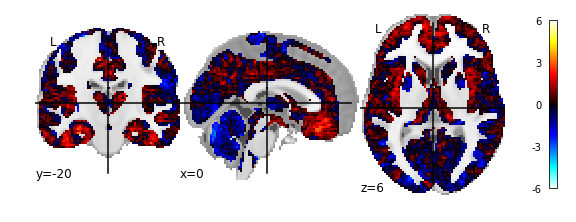

>>>GRADIENT 7 <<<<


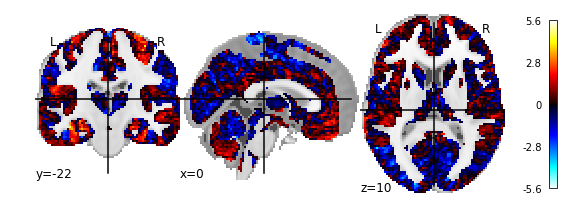

>>>GRADIENT 8 <<<<


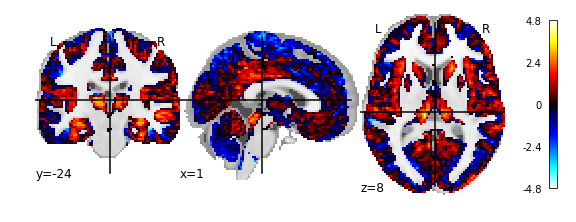

In [58]:
dmskr = mskr.fit(ni.load(scans[0])) # initiate mask

for i in range(emb['emb'].shape[-1]): # for each gradient
    # if gradient significantly associated with genomic gradient
    if dme_ress.loc[i,'p(corrected)'] < 0.05:
        print('>>>GRADIENT %s <<<<'%(i+1))
        dmat = np.dot(smtx.T, emb['emb'][:,i]) # get voxelwise weights
        dmat = ((dmat - dmat.mean()) / dmat.std()) * -1 # mean center
        # reverse the sign of Gradients 6:
        if i == 6:
            dmat *= -1
        dmat = dmat.reshape(1,len(dmat)) # convert to transformable shape
        dmat_i = dmskr.inverse_transform(dmat).get_data() # transform to image spaace
        dmat_i = dmat_i.reshape(dmat_i.shape[:3]) # reshape back to 3D space
        dmat_img = ni.Nifti1Image(dmat_i, affine=mni2mm.affine) # make back into nii object
        # plot
        plt.close()
        plotting.plot_stat_map(dmat_img)
        plt.show()
        # save
        dmat_img.to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/Diffusion_Map_Embedding/DME_STRUCT_CTX_Gradient%s'%i)

In [50]:
dmat = np.dot(smtx.T, emb['emb'][:,0])

In [51]:
dmat = dmat.reshape(1,len(dmat))
dmat = ((dmat - dmat.mean()) / dmat.std()) * -1

In [52]:
dmat_i = dmskr.inverse_transform(dmat).get_data()
dmat_i = dmat_i.reshape(dmat_i.shape[:3])
dmat_img = ni.Nifti1Image(dmat_i, affine=mni2mm.affine)

In [53]:
plotting.view_img(dmat_img)

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
